# Option 1

In this workflow, the intend is to calibrate the glen parameter A to be the closest from the one of the consensus or of Millan observations.

In [24]:
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm as colormap
from oggm import cfg, utils, workflow, tasks, graphics
from oggm.core import climate, massbalance, flowline

import pandas as pd
import geopandas as gpd
import numpy as np
from oggm.shop import bedtopo,gcm_climate

import add_data
import work_tasks
import graph

cfg.initialize(logging_level='WARNING')
cfg.PATHS['working_dir'] =  '/home/lucillegimenes/oggm-workflow-b/'
cfg.PARAMS['use_multiprocessing']=True
# We tell OGGM to continue despite of errors
cfg.PARAMS['continue_on_error'] = True

# The RGI version to use
# Size of the map around the glacier.
prepro_border = 80
# Degree of processing level. This is OGGM specific and for the shop 1 is the one you want
from_prepro_level = 3
# URL of the preprocessed gdirs
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/L3-L5_files/CRU/elev_bands/qc3/pcp2.5/no_match/'

2021-11-15 18:46:37: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-11-15 18:46:37: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2021-11-15 18:46:37: oggm.cfg: Multiprocessing: using all available processors (N=8)
2021-11-15 18:46:37: oggm.cfg: Multiprocessing switched ON after user settings.
2021-11-15 18:46:37: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.


## Getting all the glaciers from the basin


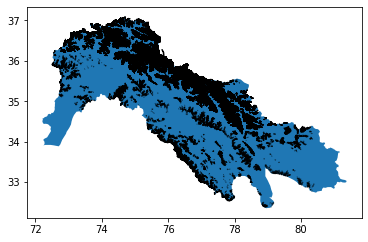

In [25]:

path_test='/home/lucillegimenes/shp_wr/Himalaya_WaterResources_20201006.shp'
basin = gpd.read_file(path_test)
basin=basin.loc[[3],:] #LaPaz 0 2020-10-05_ContourWaterResources.shp, Karakoram 3 Himalaya_WaterResources_20201006.shp

fr = utils.get_rgi_region_file(14) 
gdf = gpd.read_file(fr)

fr2 = utils.get_rgi_region_file(13) 
gdf2 = gpd.read_file(fr2)

gdf_tot=pd.concat([gdf,gdf2],axis=0)

import shapely.geometry as shpg
in_bas = [basin.geometry.contains(shpg.Point(x, y))[3] for
          (x, y) in zip(gdf_tot.CenLon, gdf_tot.CenLat)] #nb in brackets has to be the index in loc above

gdf_sel = gdf_tot.loc[in_bas]

ax=basin.plot()
gdf_sel.plot(ax=ax, edgecolor='k');

In [3]:
sel=gdf_sel["RGIId"]
rgi_ids=sel.values.tolist()

In [4]:
len(rgi_ids)

14529

In [73]:
smaller=gdf_sel.loc[gdf_sel['Area']<1,:]
bigger= gdf_sel.loc[(gdf_sel['Area']>=1) & (gdf_sel['RGIId']!='RGI60-14.05675') & (gdf_sel['RGIId']!='RGI60-14.04404')
                    & (gdf_sel['RGIId']!='RGI60-14.05749') & (gdf_sel['RGIId']!='RGI60-14.08485') &
                     (gdf_sel['RGIId']!='RGI60-14.01649')
                    ,:]
sel=bigger["RGIId"]
rgi_ids=sel.values.tolist()

a_s=smaller[['Area']].sum(axis=0)[0]
a_b=bigger[['Area']].sum(axis=0)[0]
ratio_s=a_s/(gdf_sel[['Area']].sum(axis=0)[0])*100
ratio_b=a_b/(gdf_sel[['Area']].sum(axis=0)[0])*100

print(ratio_s,ratio_b)

14.226987539439762 84.40170542522088


In [74]:
len(rgi_ids)

2404

## Working on a special set of glaciers

In [26]:
new_rgi_ids=[]
for i in range(0,405):
    count=36903
    new_count=count+i
    new_count=str(new_count)
    new_rgi_ids.append('RGI60-13.'+new_count+'')

In [27]:
spe_set=gdf_tot.loc[gdf_tot['RGIId'].isin(new_rgi_ids)]

In [28]:
smaller=spe_set.loc[spe_set['Area']<2,:]
bigger= spe_set.loc[(spe_set['Area']>=2),:]

sel=bigger["RGIId"]
rgi_ids=sel.values.tolist()

a_s=smaller[['Area']].sum(axis=0)[0]
a_b=bigger[['Area']].sum(axis=0)[0]
ratio_s=a_s/(spe_set[['Area']].sum(axis=0)[0])*100
ratio_b=a_b/(spe_set[['Area']].sum(axis=0)[0])*100

print(ratio_s,ratio_b)

19.939357913737727 80.06064208626228


In [6]:
len(rgi_ids)

94

## Get Millan volume (don't need to be run again)

In [17]:
gdirs = workflow.init_glacier_directories(rgi_ids,
                                          from_prepro_level=from_prepro_level,
                                          prepro_base_url=base_url,
                                          prepro_border=prepro_border)
for gdir in gdirs:

    gdir.name_corr=gdir.name.replace('/','-')
    if (gdir.name==''):
        gdir.name_corr='Aletsch'


    #Little adjustment  
    if (gdir.rgi_region in ['13','14','15']):
        gdir.rgi_region_m='13-15'
    else:
        gdir.rgi_region_m=gdir.rgi_region

    add_data.add_data_thickness(gdir,'/home/lucillegimenes/Bureau/THICKNESS_Millan/RGI-'+gdir.rgi_region_m+'/per_glacier/'+gdir.rgi_id+'_thickness_m_from_f.tif')
 
    
    with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
        ds = ds.load()

    #new dataframe to add
    vol=int(ds.millan_thickness.where(ds.glacier_mask==1).sum())*(int(ds.y[0]-ds.y[1])**2)
    """columns=['volume_m3']
    index=[gdir.rgi_id]
    df=pd.DataFrame(data=vol,index=index,columns=columns)
    df.index.name='RGIId'

    old=pd.read_hdf('/home/lucillegimenes/volumes_millan_rgi13.h5')

    new=pd.concat([old,df],axis=0)

    #save 
    store = pd.HDFStore('volumes_millan_rgi13.h5')
    store.put('dataset_01', new)
    store.close()"""


2021-11-15 18:20:46: oggm.workflow: init_glacier_directories from prepro level 3 on 94 glaciers.
2021-11-15 18:20:46: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 94 glaciers


### Checking if everything alright

In [15]:
test=pd.read_hdf('/home/lucillegimenes/volumes_millan_rgi13.h5')
test

,volume_m3
RGIId,
RGI60-13.36903,229626000
RGI60-13.36904,517410738
RGI60-13.36907,2682316659
RGI60-13.36908,582250100
RGI60-13.36909,196893378
...,...
RGI60-13.37294,242900301
RGI60-13.37299,90857457
RGI60-13.37300,553199616


In [12]:
df = pd.read_hdf(utils.get_demo_file('rgi62_itmix_df.h5'))
df = df.reindex(rgi_ids)

In [13]:
df2=df.drop(labels=['vol_bsl_itmix_m3'],axis=1)
df3=pd.concat([df2,test],axis=1)

In [14]:
df3=df3.assign(diff_rel=((df3['volume_m3']-df3['vol_itmix_m3'])/df3['vol_itmix_m3'])*100)
df3

,vol_itmix_m3,volume_m3,diff_rel
RGIId,,,
RGI60-13.36903,8.623383e+07,229626000,166.282972
RGI60-13.36904,2.411387e+08,517410738,114.569736
RGI60-13.36907,1.386068e+09,2682316659,93.519894
RGI60-13.36908,3.132949e+08,582250100,85.847271
RGI60-13.36909,1.073316e+08,196893378,83.443945
...,...,...,...
RGI60-13.37294,1.813539e+08,242900301,33.937176
RGI60-13.37299,6.148985e+07,90857457,47.760080
RGI60-13.37300,4.325414e+08,553199616,27.895193


### Checking how close is the calculation of the volume to the one stored in the .h5

In [26]:
gdirs = workflow.init_glacier_directories(['RGI60-13.36903'],
                                          from_prepro_level=from_prepro_level,
                                          prepro_base_url=base_url,
                                          prepro_border=prepro_border)
gdir=gdirs[0]

workflow.execute_entity_task(bedtopo.add_consensus_thickness, gdir)
   
with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
    ds = ds.load()


2021-11-15 08:30:50: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2021-11-15 08:30:50: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2021-11-15 08:30:50: oggm.workflow: Execute entity tasks [add_consensus_thickness] on 1 glaciers
100% of  39.7 KiB |######################| Elapsed Time: 0:00:00 Time:  0:00:00


In [28]:
    #new dataframe to add
vol=int(ds.consensus_ice_thickness.where(ds.glacier_mask==1).sum())*(int(ds.y[0]-ds.y[1])**2)
vol

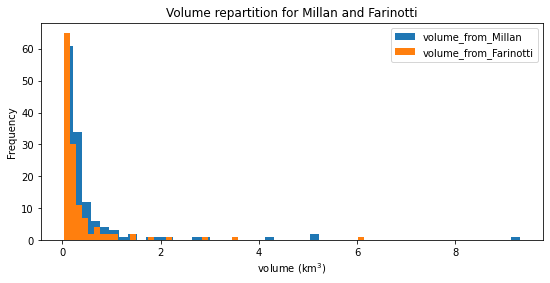

In [24]:
df3=df3.rename(columns={'vol_itmix_m3':'volume_from_Farinotti','volume_m3':'volume_from_Millan'})
f, ax = plt.subplots(figsize=(9, 4))
(df3[['volume_from_Millan']]*10**-9).plot(ax=ax,kind='hist', bins=(50))
(df3[['volume_from_Farinotti']]*10**-9).plot(ax=ax,kind='hist', bins=(50))


plt.legend()
plt.title('Volume repartition for Millan and Farinotti')
plt.xlabel('volume ($\mathregular{km^3}$)')
name = 'Himalaya_volume_hist.png'
plt.savefig(name, format = 'png')

In [20]:
df3

,vol_itmix_m3,volume_m3,diff_rel
RGIId,,,
RGI60-13.36903,8.623383e+07,229626000,166.282972
RGI60-13.36904,2.411387e+08,517410738,114.569736
RGI60-13.36907,1.386068e+09,2682316659,93.519894
RGI60-13.36908,3.132949e+08,582250100,85.847271
RGI60-13.36909,1.073316e+08,196893378,83.443945
...,...,...,...
RGI60-13.37294,1.813539e+08,242900301,33.937176
RGI60-13.37299,6.148985e+07,90857457,47.760080
RGI60-13.37300,4.325414e+08,553199616,27.895193


In [69]:
df3['diff'].median()

70049607.9375

In [70]:
df3['diff_rel'].median()

46.16265975509168

In [71]:
df3['diff'].mean()

196658957.25325522

In [72]:
df3['diff_rel'].mean()

56.28543803544463

## Calibrating the volume on the observations

Before running simulations, we have to examine how evolves the ice thickness along the flowline regarding the original thicknesses from Farinotti or Millan

In [76]:
import work_tasks


diag=[{'farinotti':[0,0],'millan':[0,0]}]*len(rgi_ids)
eps=[{'farinotti':0,'millan':0}]*len(rgi_ids)
diag_0=[0]*len(rgi_ids)
diag_f=[0]*len(rgi_ids)
diag_m=[0]*len(rgi_ids)


dff= pd.read_hdf(utils.get_demo_file('rgi62_itmix_df.h5'))
dfm=pd.read_hdf('/home/lucillegimenes/volumes_millan_rgi13.h5')

path_to_hdf='/home/lucillegimenes/volumes_millan_rgi13.h5'

vreff=[0]*len(rgi_ids)
vrefm=[0]*len(rgi_ids)
vf=[0]*len(rgi_ids)
vm=[0]*len(rgi_ids)

diff=[0]*len(rgi_ids)
difm=[0]*len(rgi_ids)

for data in ['millan','farinotti']:
    print(data)
    gdirs = workflow.init_glacier_directories(rgi_ids,from_prepro_level=3,
                                                  prepro_border=prepro_border)
    
    for gdir in gdirs:
        workflow.execute_entity_task(tasks.init_present_time_glacier, gdir)
        ind=gdirs.index(gdir)
        diag_0[ind]= gdir.get_diagnostics()
        vreff[ind]=dff.loc[gdir.rgi_id,:][0]
        vrefm[ind]=dfm.loc[gdir.rgi_id,:][0]
    
        if (data=='farinotti'):
            workflow.calibrate_inversion_from_consensus(gdir,apply_fs_on_mismatch=True,error_on_mismatch=False)
            workflow.execute_entity_task(tasks.init_present_time_glacier, gdir)
            diag_f[ind]=gdir.get_diagnostics()
            if 'inversion_glen_a' in diag_f[ind]:
                vf[ind] = tasks.mass_conservation_inversion(gdir, glen_a=diag_f[ind]['inversion_glen_a'], write=False)
                diff[ind]=((vf[ind]-vreff[ind])/vreff[ind])*100

        else:
            work_tasks.calibrate_inversion_from_millan(gdir,path_to_hdf,apply_fs_on_mismatch=True,error_on_mismatch=False,a_bounds=(0.001,10))
            workflow.execute_entity_task(tasks.init_present_time_glacier, gdir)
            diag_m[ind]=gdir.get_diagnostics()
            if 'inversion_glen_a' in diag_m[ind]:
                vm[ind]= tasks.mass_conservation_inversion(gdir, glen_a=diag_m[ind]['inversion_glen_a'], write=False)
                difm[ind]=((vm[ind]-vrefm[ind])/vrefm[ind])*100

        

2021-11-15 19:00:25: oggm.workflow: init_glacier_directories from prepro level 3 on 94 glaciers.


millan


2021-11-15 19:00:25: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 94 glaciers
2021-11-15 19:00:30: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 19:00:30: work_tasks: Consensus estimate optimisation with A factor: 0.001 and fs: 0
2021-11-15 19:00:30: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:30: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:30: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:30: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:30: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:30: work_tasks: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-15 19:00:30: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:30: oggm.workflow: Execute entity tasks [

2021-11-15 19:00:31: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:31: work_tasks: Consensus estimate optimisation with A factor: 0.005642883152656995 and fs: 0
2021-11-15 19:00:31: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:31: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:31: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:31: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:31: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:31: work_tasks: calibrate_inversion_from_consensus converged after 14 iterations and fs=0. The resulting Glen A factor is 0.00567123935040904.
2021-11-15 19:00:31: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:31: oggm.workflow: Execute entity tasks [prepare_for_inve

2021-11-15 19:00:31: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:31: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:31: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:31: work_tasks: Consensus estimate optimisation with A factor: 0.016061367950562944 and fs: 0
2021-11-15 19:00:31: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:31: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:31: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:31: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:31: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:31: work_tasks: Consensus estimate optimisation with A factor: 0.015678615977062133 and fs: 0
2021-11-15 1

2021-11-15 19:00:31: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:31: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:31: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:31: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:31: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:31: work_tasks: Consensus estimate optimisation with A factor: 0.0672233467088538 and fs: 0
2021-11-15 19:00:31: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:31: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:31: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:31: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:31: oggm.workflow: E

2021-11-15 19:00:31: work_tasks: Consensus estimate optimisation with A factor: 0.0503295306304485 and fs: 0
2021-11-15 19:00:31: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:31: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:32: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:32: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:32: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:32: work_tasks: Consensus estimate optimisation with A factor: 0.04471480149613958 and fs: 0
2021-11-15 19:00:32: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:32: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:32: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:32: ogg

2021-11-15 19:00:32: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:32: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:32: work_tasks: Consensus estimate optimisation with A factor: 0.04699455218612596 and fs: 0
2021-11-15 19:00:32: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:32: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:32: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:32: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:32: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:32: work_tasks: Consensus estimate optimisation with A factor: 0.03574085540245403 and fs: 0
2021-11-15 19:00:32: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:32: oggm.wo

2021-11-15 19:00:32: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:32: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:32: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:32: work_tasks: Consensus estimate optimisation with A factor: 0.04337860236250665 and fs: 0
2021-11-15 19:00:32: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:32: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:32: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:32: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:32: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:32: work_tasks: Consensus estimate optimisation with A factor: 0.022189301181253326 and fs: 0
2021-11-15 19

2021-11-15 19:00:32: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:32: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:32: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:32: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:32: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:32: work_tasks: Consensus estimate optimisation with A factor: 0.15768976788595243 and fs: 0
2021-11-15 19:00:32: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:32: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:32: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:32: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:32: oggm.workflow: 

2021-11-15 19:00:33: work_tasks: Consensus estimate optimisation with A factor: 1.4125815045608712 and fs: 0
2021-11-15 19:00:33: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:33: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:33: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:33: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:33: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:33: work_tasks: Consensus estimate optimisation with A factor: 0.7067907522804355 and fs: 0
2021-11-15 19:00:33: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:33: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:33: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:33: oggm

2021-11-15 19:00:33: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:33: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:33: work_tasks: Consensus estimate optimisation with A factor: 2.6080311202631767 and fs: 0
2021-11-15 19:00:33: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:33: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:33: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:33: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:33: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:33: work_tasks: Consensus estimate optimisation with A factor: 1.3045155601315883 and fs: 0
2021-11-15 19:00:33: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:33: oggm.work

2021-11-15 19:00:33: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:33: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:33: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:33: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:33: work_tasks: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-15 19:00:33: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:33: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:33: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:33: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:33: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:33: work_tasks: Consensus e

2021-11-15 19:00:33: work_tasks: Consensus estimate optimisation with A factor: 0.001 and fs: 0
2021-11-15 19:00:33: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:33: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:33: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:33: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:33: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:33: work_tasks: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-15 19:00:33: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:33: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:33: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:33: oggm.workflow: Execute entity t

2021-11-15 19:00:34: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:34: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:34: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:34: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:34: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:34: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 19:00:34: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 19:00:34: work_tasks: Consensus estimate optimisation with A factor: 0.001 and fs: 0
2021-11-15 19:00:34: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:34: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:34: oggm.workflow: Execute entity

2021-11-15 19:00:34: work_tasks: Consensus estimate optimisation with A factor: 0.040510125023732725 and fs: 0
2021-11-15 19:00:34: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:34: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:34: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:34: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:34: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:34: work_tasks: calibrate_inversion_from_consensus converged after 13 iterations and fs=0. The resulting Glen A factor is 0.04071369349219369.
2021-11-15 19:00:34: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:34: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:34: oggm.workflow: Execute entity tasks [mass_conservati

2021-11-15 19:00:34: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:34: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:34: work_tasks: Consensus estimate optimisation with A factor: 0.0521400298811316 and fs: 0
2021-11-15 19:00:34: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:34: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:34: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:34: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:34: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:34: work_tasks: calibrate_inversion_from_consensus converged after 12 iterations and fs=0. The resulting Glen A factor is 0.05240204008254432.
2021-11-15 19:00:34: oggm.workflow: Applying global task inversion

2021-11-15 19:00:35: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:35: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:35: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:35: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:35: work_tasks: Consensus estimate optimisation with A factor: 0.022961305412028604 and fs: 0
2021-11-15 19:00:35: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:35: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:35: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:35: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:35: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:35: work_ta

2021-11-15 19:00:35: work_tasks: Consensus estimate optimisation with A factor: 0.02348510618260362 and fs: 0
2021-11-15 19:00:35: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:35: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:35: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:35: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:35: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:35: work_tasks: Consensus estimate optimisation with A factor: 0.03279383594272906 and fs: 0
2021-11-15 19:00:35: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:35: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:35: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:35: og

2021-11-15 19:00:35: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:35: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:35: work_tasks: Consensus estimate optimisation with A factor: 0.07128785831013387 and fs: 0
2021-11-15 19:00:35: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:35: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:35: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:35: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:35: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:35: work_tasks: Consensus estimate optimisation with A factor: 0.08828733953987854 and fs: 0
2021-11-15 19:00:35: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:35: oggm.wo

2021-11-15 19:00:36: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:36: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:36: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:36: work_tasks: Consensus estimate optimisation with A factor: 0.0500682421614552 and fs: 0
2021-11-15 19:00:36: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:36: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:36: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:36: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:36: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:36: work_tasks: Consensus estimate optimisation with A factor: 0.044661458492653315 and fs: 0
2021-11-15 19:

2021-11-15 19:00:36: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:36: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:36: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:36: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:36: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:36: work_tasks: Consensus estimate optimisation with A factor: 0.03719171009543934 and fs: 0
2021-11-15 19:00:36: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:36: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:36: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:36: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:36: oggm.workflow: 

2021-11-15 19:00:36: work_tasks: Consensus estimate optimisation with A factor: 0.3840118206897774 and fs: 0
2021-11-15 19:00:36: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:36: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:36: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:36: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:36: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:36: work_tasks: Consensus estimate optimisation with A factor: 0.1925059103448887 and fs: 0
2021-11-15 19:00:36: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:36: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:36: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:36: oggm

2021-11-15 19:00:36: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:36: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:36: work_tasks: Consensus estimate optimisation with A factor: 0.7300475221708013 and fs: 0
2021-11-15 19:00:36: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:36: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:36: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:36: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:36: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:36: work_tasks: Consensus estimate optimisation with A factor: 0.36552376108540063 and fs: 0
2021-11-15 19:00:36: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:36: oggm.wor

2021-11-15 19:00:37: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:37: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:37: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:37: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:37: work_tasks: Consensus estimate optimisation with A factor: 0.04303831448232673 and fs: 0
2021-11-15 19:00:37: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:37: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:37: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:37: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:37: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:37: work_tas

2021-11-15 19:00:37: work_tasks: Consensus estimate optimisation with A factor: 0.622885673861787 and fs: 0
2021-11-15 19:00:37: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:37: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:37: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:37: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:37: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:37: work_tasks: Consensus estimate optimisation with A factor: 0.3119428369308935 and fs: 0
2021-11-15 19:00:37: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:37: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:37: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:37: oggm.

2021-11-15 19:00:37: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:37: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:37: work_tasks: Consensus estimate optimisation with A factor: 2.826675025359055 and fs: 0
2021-11-15 19:00:37: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:37: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:37: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:37: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:37: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:37: work_tasks: Consensus estimate optimisation with A factor: 1.4138375126795275 and fs: 0
2021-11-15 19:00:37: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:37: oggm.workf

2021-11-15 19:00:38: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:38: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:38: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:38: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:38: work_tasks: Consensus estimate optimisation with A factor: 5.448899764620734 and fs: 0
2021-11-15 19:00:38: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:38: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:38: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:38: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:38: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:38: work_tasks

2021-11-15 19:00:38: work_tasks: Consensus estimate optimisation with A factor: 0.001 and fs: 0
2021-11-15 19:00:38: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:38: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:38: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:38: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:38: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:38: work_tasks: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-15 19:00:38: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:38: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:38: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:38: oggm.workflow: Execute entity t

2021-11-15 19:00:38: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 19:00:38: work_tasks: Consensus estimate optimisation with A factor: 0.001 and fs: 0
2021-11-15 19:00:38: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:38: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:38: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:38: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:38: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:38: work_tasks: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-15 19:00:38: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:38: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:38: oggm.workflow: Execute entity tas

2021-11-15 19:00:38: work_tasks: calibrate_inversion_from_consensus converged after 13 iterations and fs=0. The resulting Glen A factor is 0.0053167245932484114.
2021-11-15 19:00:38: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:38: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:38: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:38: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:38: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:38: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 19:00:38: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 19:00:38: work_tasks: Consensus estimate optimisation with A factor: 0.001 and fs: 0
2021-11-15 19:00:38: oggm.workflow: Applying global task inversion_tas

2021-11-15 19:00:39: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:39: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:39: work_tasks: Consensus estimate optimisation with A factor: 0.013032819508150722 and fs: 0
2021-11-15 19:00:39: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:39: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:39: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:39: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:39: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:39: work_tasks: Consensus estimate optimisation with A factor: 0.012939776883525754 and fs: 0
2021-11-15 19:00:39: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:39: oggm.

2021-11-15 19:00:39: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:39: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:39: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:39: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:39: work_tasks: Consensus estimate optimisation with A factor: 0.09019385495904882 and fs: 0
2021-11-15 19:00:39: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:39: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:39: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:39: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:39: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:39: work_tas

2021-11-15 19:00:39: work_tasks: Consensus estimate optimisation with A factor: 0.35609250686311494 and fs: 0
2021-11-15 19:00:39: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:39: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:39: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:39: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:39: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:39: work_tasks: Consensus estimate optimisation with A factor: 0.17854625343155747 and fs: 0
2021-11-15 19:00:39: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:39: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:39: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:39: og

2021-11-15 19:00:39: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:39: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:39: work_tasks: Consensus estimate optimisation with A factor: 1.0866555942486682 and fs: 0
2021-11-15 19:00:39: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:39: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:39: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:39: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:40: work_tasks: Consensus estimate optimisation with A factor: 0.543827797124334 and fs: 0
2021-11-15 19:00:40: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:40: oggm.workf

2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:40: work_tasks: Consensus estimate optimisation with A factor: 0.20296537656602626 and fs: 0
2021-11-15 19:00:40: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:40: work_tasks: Consensus estimate optimisation with A factor: 0.10198268828301313 and fs: 0
2021-11-15 19:

2021-11-15 19:00:40: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:40: work_tasks: Consensus estimate optimisation with A factor: 0.04748700929481451 and fs: 0
2021-11-15 19:00:40: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:40: oggm.workflow: 

2021-11-15 19:00:40: work_tasks: Consensus estimate optimisation with A factor: 0.4239608147315946 and fs: 0
2021-11-15 19:00:40: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:40: work_tasks: Consensus estimate optimisation with A factor: 0.2124804073657973 and fs: 0
2021-11-15 19:00:40: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:40: oggm

2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:40: work_tasks: Consensus estimate optimisation with A factor: 0.3769922551599805 and fs: 0
2021-11-15 19:00:40: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:40: work_tasks: Consensus estimate optimisation with A factor: 0.18899612757999026 and fs: 0
2021-11-15 19:00:40: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:40: oggm.wor

2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:40: work_tasks: Consensus estimate optimisation with A factor: 1.687933419787635 and fs: 0
2021-11-15 19:00:40: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:40: work_tasks

2021-11-15 19:00:40: work_tasks: Consensus estimate optimisation with A factor: 3.5472810656603504 and fs: 0
2021-11-15 19:00:40: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:40: work_tasks: Consensus estimate optimisation with A factor: 1.7741405328301751 and fs: 0
2021-11-15 19:00:40: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:40: oggm

2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:40: work_tasks: Consensus estimate optimisation with A factor: 3.7002945674277874 and fs: 0
2021-11-15 19:00:40: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:40: work_tasks: Consensus estimate optimisation with A factor: 1.8506472837138936 and fs: 0
2021-11-15 19:00:40: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:40: oggm.work

2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:40: work_tasks: Consensus estimate optimisation with A factor: 1.428370055285952 and fs: 0
2021-11-15 19:00:40: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:40: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:40: work_tasks: Consensus estimate optimisation with A factor: 0.7146850276429759 and fs: 0
2021-11-15 19:00:

2021-11-15 19:00:41: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:41: work_tasks: Consensus estimate optimisation with A factor: 3.419134252272159 and fs: 0
2021-11-15 19:00:41: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: Ex

2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:41: work_tasks: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-15 19:00:41: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:41: work_tasks: Consensus estimate optimisation with A factor: 8.974576138466285 and fs: 0
2021-11-15 19:00:41: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: Execute ent

2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:41: work_tasks: Consensus estimate optimisation with A factor: 0.8195134315262415 and fs: 0
2021-11-15 19:00:41: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:41: work_tasks: Consensus estimate optimisation with A factor: 0.4102567157631207 and fs: 0
2021-11-15 19:00:41: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:41: oggm.work

2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:41: work_tasks: Consensus estimate optimisation with A factor: 0.20119069535361564 and fs: 0
2021-11-15 19:00:41: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:41: work_tasks: Consensus estimate optimisation with A factor: 0.10109534767680782 and fs: 0
2021-11-15 19:

2021-11-15 19:00:41: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:41: work_tasks: Consensus estimate optimisation with A factor: 0.2905354702939218 and fs: 0
2021-11-15 19:00:41: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: E

2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:41: work_tasks: Consensus estimate optimisation with A factor: 4.007805961681709 and fs: 0
2021-11-15 19:00:41: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:41: work_tasks: Consensus estimate optimisation with A factor: 2.0044029808408546 and fs: 0
2021-11-15 19:00:41: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:41: oggm.workf

2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:41: work_tasks: Consensus estimate optimisation with A factor: 0.8825542819365064 and fs: 0
2021-11-15 19:00:41: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:41: work_tasks: Consensus estimate optimisation with A factor: 0.4417771409682532 and fs: 0
2021-11-15 19:00

2021-11-15 19:00:41: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:41: work_tasks: Consensus estimate optimisation with A factor: 3.0038174427701407 and fs: 0
2021-11-15 19:00:41: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:41: oggm.workflow: E

2021-11-15 19:00:42: work_tasks: Consensus estimate optimisation with A factor: 0.32685298051852807 and fs: 0
2021-11-15 19:00:42: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:42: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:42: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:42: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:42: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:42: work_tasks: Consensus estimate optimisation with A factor: 0.3284872454221207 and fs: 0
2021-11-15 19:00:42: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:42: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:42: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:42: ogg

2021-11-15 19:00:42: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:42: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:42: work_tasks: Consensus estimate optimisation with A factor: 0.09509879680675236 and fs: 0
2021-11-15 19:00:42: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:42: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:42: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:42: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:42: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:42: work_tasks: calibrate_inversion_from_consensus converged after 11 iterations and fs=0. The resulting Glen A factor is 0.09509879680675236.
2021-11-15 19:00:42: oggm.workflow: Applying global task inversio

2021-11-15 19:00:42: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:42: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:42: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:42: work_tasks: calibrate_inversion_from_consensus converged after 11 iterations and fs=0. The resulting Glen A factor is 0.10875757638607632.
2021-11-15 19:00:42: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:42: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:42: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:42: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:42: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:42: oggm.workflow: Execute entity tasks [init_present_tim

2021-11-15 19:00:42: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:42: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:42: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:42: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:42: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:42: work_tasks: Consensus estimate optimisation with A factor: 0.07299165862332149 and fs: 0
2021-11-15 19:00:42: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:42: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:42: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:42: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:42: oggm.workflow: 

2021-11-15 19:00:42: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:42: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:42: work_tasks: Consensus estimate optimisation with A factor: 8.036432701280981 and fs: 0
2021-11-15 19:00:42: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:42: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:42: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:42: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:42: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:42: work_tasks: Consensus estimate optimisation with A factor: 4.01871635064049 and fs: 0
2021-11-15 19:00:42: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:42: oggm.workflo

2021-11-15 19:00:42: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:43: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:43: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:43: work_tasks: Consensus estimate optimisation with A factor: 1.8734936023830677 and fs: 0
2021-11-15 19:00:43: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:43: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:43: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:43: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:43: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:43: work_tasks: Consensus estimate optimisation with A factor: 0.9372468011915338 and fs: 0
2021-11-15 19:00

2021-11-15 19:00:43: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:43: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:43: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:43: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:43: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:43: work_tasks: Consensus estimate optimisation with A factor: 0.7739024450959212 and fs: 0
2021-11-15 19:00:43: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:43: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:43: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:43: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:43: oggm.workflow: E

2021-11-15 19:00:43: work_tasks: Consensus estimate optimisation with A factor: 1.7284411552012298 and fs: 0
2021-11-15 19:00:43: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:43: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:43: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:43: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:43: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:43: work_tasks: Consensus estimate optimisation with A factor: 0.8647205776006148 and fs: 0
2021-11-15 19:00:43: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:43: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:43: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:43: oggm

2021-11-15 19:00:43: oggm.core.inversion: FileNotFoundError occurred during task get_inversion_volume on RGI60-13.37185: [Errno 2] No such file or directory: '/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.37/RGI60-13.37185/inversion_output.pkl'
2021-11-15 19:00:43: work_tasks: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-15 19:00:43: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:43: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:43: oggm.core.inversion: TypeError occurred during task prepare_for_inversion on RGI60-13.37185: unsupported operand type(s) for *: 'NoneType' and 'float'
2021-11-15 19:00:43: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:43: oggm.core.inversion: FileNotFoundError occurred during task mass_conservation_inversion on RGI60-13.37185: [Errno 2] No such file or directory: '/home/lucillegimen

2021-11-15 19:00:43: oggm.core.inversion: FileNotFoundError occurred during task filter_inversion_output on RGI60-13.37186: [Errno 2] No such file or directory: '/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.37/RGI60-13.37186/inversion_output.pkl'
2021-11-15 19:00:43: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:43: oggm.core.inversion: FileNotFoundError occurred during task get_inversion_volume on RGI60-13.37186: [Errno 2] No such file or directory: '/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.37/RGI60-13.37186/inversion_output.pkl'
2021-11-15 19:00:43: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 19:00:43: oggm.core.flowline: FileNotFoundError occurred during task init_present_time_glacier on RGI60-13.37186: [Errno 2] No such file or directory: '/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.37/RGI60-13.37186/inversion_output.pkl'
20

2021-11-15 19:00:44: work_tasks: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-15 19:00:44: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:44: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:44: oggm.core.inversion: TypeError occurred during task prepare_for_inversion on RGI60-13.37188: unsupported operand type(s) for *: 'NoneType' and 'float'
2021-11-15 19:00:44: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:44: oggm.core.inversion: FileNotFoundError occurred during task mass_conservation_inversion on RGI60-13.37188: [Errno 2] No such file or directory: '/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.37/RGI60-13.37188/inversion_input.pkl'
2021-11-15 19:00:44: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:44: oggm.core.inversion: FileNotFoundError occurred during task 

2021-11-15 19:00:44: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:44: oggm.core.inversion: FileNotFoundError occurred during task get_inversion_volume on RGI60-13.37189: [Errno 2] No such file or directory: '/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.37/RGI60-13.37189/inversion_output.pkl'
2021-11-15 19:00:44: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 19:00:44: oggm.core.flowline: FileNotFoundError occurred during task init_present_time_glacier on RGI60-13.37189: [Errno 2] No such file or directory: '/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.37/RGI60-13.37189/inversion_output.pkl'
2021-11-15 19:00:44: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 19:00:44: work_tasks: Consensus estimate optimisation with A factor: 0.001 and fs: 0
2021-11-15 19:00:44: oggm.workflow: Applying global task inversion_tasks on 

2021-11-15 19:00:44: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:44: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:44: work_tasks: calibrate_inversion_from_consensus converged after 12 iterations and fs=0. The resulting Glen A factor is 0.07103404048333833.
2021-11-15 19:00:44: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:44: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:44: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:44: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:44: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:44: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 19:00:44: oggm.workflow: Execute entity tasks [init_present_time_

2021-11-15 19:00:44: work_tasks: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-15 19:00:44: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:44: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:44: oggm.core.inversion: TypeError occurred during task prepare_for_inversion on RGI60-13.37197: unsupported operand type(s) for *: 'NoneType' and 'float'
2021-11-15 19:00:44: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:44: oggm.core.inversion: FileNotFoundError occurred during task mass_conservation_inversion on RGI60-13.37197: [Errno 2] No such file or directory: '/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.37/RGI60-13.37197/inversion_input.pkl'
2021-11-15 19:00:44: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:44: oggm.core.inversion: FileNotFoundError occurred during task 

2021-11-15 19:00:44: work_tasks: Consensus estimate optimisation with A factor: 0.11148309967439389 and fs: 0
2021-11-15 19:00:44: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:44: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:44: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:44: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:44: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:44: work_tasks: Consensus estimate optimisation with A factor: 0.08331526538831424 and fs: 0
2021-11-15 19:00:45: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:45: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:45: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:45: og

2021-11-15 19:00:45: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:45: oggm.core.inversion: FileNotFoundError occurred during task get_inversion_volume on RGI60-13.37201: [Errno 2] No such file or directory: '/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.37/RGI60-13.37201/inversion_output.pkl'
2021-11-15 19:00:45: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 19:00:45: oggm.core.flowline: FileNotFoundError occurred during task init_present_time_glacier on RGI60-13.37201: [Errno 2] No such file or directory: '/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.37/RGI60-13.37201/inversion_output.pkl'
2021-11-15 19:00:45: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 19:00:45: oggm.core.flowline: FileNotFoundError occurred during task init_present_time_glacier on RGI60-13.37205: [Errno 2] No such file or directory: '/home/luc

2021-11-15 19:00:45: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:45: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:45: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:45: work_tasks: Consensus estimate optimisation with A factor: 1.6811113911876019 and fs: 0
2021-11-15 19:00:45: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:45: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:45: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:45: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:45: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:45: work_tasks: Consensus estimate optimisation with A factor: 0.8410556955938009 and fs: 0
2021-11-15 19:00

2021-11-15 19:00:45: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:45: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:45: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:45: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:45: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:45: work_tasks: Consensus estimate optimisation with A factor: 1.7565199821735977 and fs: 0
2021-11-15 19:00:45: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:45: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:45: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:45: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:45: oggm.workflow: E

2021-11-15 19:00:45: work_tasks: Consensus estimate optimisation with A factor: 4.125271322223678 and fs: 0
2021-11-15 19:00:45: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:45: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:45: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:45: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:45: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:45: work_tasks: Consensus estimate optimisation with A factor: 2.063135661111839 and fs: 0
2021-11-15 19:00:45: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:45: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:46: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:46: oggm.w

2021-11-15 19:00:46: oggm.core.inversion: FileNotFoundError occurred during task filter_inversion_output on RGI60-13.37226: [Errno 2] No such file or directory: '/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.37/RGI60-13.37226/inversion_output.pkl'
2021-11-15 19:00:46: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:46: oggm.core.inversion: FileNotFoundError occurred during task get_inversion_volume on RGI60-13.37226: [Errno 2] No such file or directory: '/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.37/RGI60-13.37226/inversion_output.pkl'
2021-11-15 19:00:46: work_tasks: calibrate_inversion_from_consensus converged after -769354928 iterations and fs=0. The resulting Glen A factor is 0.001.
2021-11-15 19:00:46: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:46: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:46: oggm.core.inve

2021-11-15 19:00:46: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:46: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:46: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:46: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:46: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:46: work_tasks: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-15 19:00:46: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:46: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:46: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:46: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:46: oggm.workflow: Execute entity 

2021-11-15 19:00:46: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:46: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:46: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:46: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:46: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:46: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 19:00:46: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 19:00:46: work_tasks: Consensus estimate optimisation with A factor: 0.001 and fs: 0
2021-11-15 19:00:46: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:46: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:46: oggm.workflow: Execute entity

2021-11-15 19:00:46: work_tasks: calibrate_inversion_from_consensus converged after 12 iterations and fs=0. The resulting Glen A factor is 0.06820964241761612.
2021-11-15 19:00:46: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:46: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:46: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:46: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:46: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:46: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 19:00:46: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 19:00:46: oggm.core.flowline: FileNotFoundError occurred during task init_present_time_glacier on RGI60-13.37234: [Errno 2] No such file or directory: '/home

2021-11-15 19:00:47: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:47: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:47: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:47: work_tasks: Consensus estimate optimisation with A factor: 1.5837224776137826 and fs: 0
2021-11-15 19:00:47: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:47: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:47: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:47: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:47: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:47: work_tasks: Consensus estimate optimisation with A factor: 0.7923612388068912 and fs: 0
2021-11-15 19:00

2021-11-15 19:00:47: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:47: oggm.core.inversion: FileNotFoundError occurred during task get_inversion_volume on RGI60-13.37236: [Errno 2] No such file or directory: '/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.37/RGI60-13.37236/inversion_output.pkl'
2021-11-15 19:00:47: work_tasks: calibrate_inversion_from_consensus converged after -769354928 iterations and fs=0. The resulting Glen A factor is 0.001.
2021-11-15 19:00:47: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:47: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:47: oggm.core.inversion: TypeError occurred during task prepare_for_inversion on RGI60-13.37236: unsupported operand type(s) for *: 'NoneType' and 'float'
2021-11-15 19:00:47: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:47: oggm.core.

2021-11-15 19:00:47: work_tasks: Consensus estimate optimisation with A factor: 0.023753129176057305 and fs: 0
2021-11-15 19:00:47: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:47: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:47: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:47: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:47: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:47: work_tasks: Consensus estimate optimisation with A factor: 0.03185729345460574 and fs: 0
2021-11-15 19:00:47: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:47: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:47: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:47: o

2021-11-15 19:00:47: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:47: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:47: work_tasks: Consensus estimate optimisation with A factor: 0.04998177416614498 and fs: 0
2021-11-15 19:00:47: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:47: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:47: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:47: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:47: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:47: work_tasks: Consensus estimate optimisation with A factor: 0.038764984033507845 and fs: 0
2021-11-15 19:00:47: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:47: oggm.w

2021-11-15 19:00:48: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:48: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:48: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:48: work_tasks: Consensus estimate optimisation with A factor: 0.08782219443688963 and fs: 0
2021-11-15 19:00:48: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:48: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:48: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:48: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:48: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:48: work_tasks: Consensus estimate optimisation with A factor: 0.044411097218444814 and fs: 0
2021-11-15 19

2021-11-15 19:00:48: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:48: oggm.core.inversion: TypeError occurred during task prepare_for_inversion on RGI60-13.37246: unsupported operand type(s) for *: 'NoneType' and 'float'
2021-11-15 19:00:48: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:48: oggm.core.inversion: FileNotFoundError occurred during task mass_conservation_inversion on RGI60-13.37246: [Errno 2] No such file or directory: '/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.37/RGI60-13.37246/inversion_input.pkl'
2021-11-15 19:00:48: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:48: oggm.core.inversion: FileNotFoundError occurred during task filter_inversion_output on RGI60-13.37246: [Errno 2] No such file or directory: '/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.37/RGI60-13.37246/inversion_output

2021-11-15 19:00:48: work_tasks: Consensus estimate optimisation with A factor: 0.00995264653585375 and fs: 0
2021-11-15 19:00:48: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:48: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:48: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:48: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:48: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:48: work_tasks: Consensus estimate optimisation with A factor: 0.011870593654847637 and fs: 0
2021-11-15 19:00:48: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:48: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:48: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:48: o

2021-11-15 19:00:48: oggm.core.flowline: FileNotFoundError occurred during task init_present_time_glacier on RGI60-13.37251: [Errno 2] No such file or directory: '/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.37/RGI60-13.37251/inversion_output.pkl'
2021-11-15 19:00:48: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 19:00:48: oggm.core.flowline: FileNotFoundError occurred during task init_present_time_glacier on RGI60-13.37258: [Errno 2] No such file or directory: '/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.37/RGI60-13.37258/inversion_output.pkl'
2021-11-15 19:00:48: work_tasks: Consensus estimate optimisation with A factor: 0.001 and fs: 0
2021-11-15 19:00:48: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:48: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:48: oggm.core.inversion: TypeError occurred during task prepare_fo

2021-11-15 19:00:49: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:49: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:49: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:49: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:49: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:49: work_tasks: Consensus estimate optimisation with A factor: 1.075629187935735 and fs: 0
2021-11-15 19:00:49: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:49: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:49: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:49: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:49: oggm.workflow: Ex

2021-11-15 19:00:49: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:49: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:49: oggm.core.inversion: TypeError occurred during task prepare_for_inversion on RGI60-13.37264: unsupported operand type(s) for *: 'NoneType' and 'float'
2021-11-15 19:00:49: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:49: oggm.core.inversion: FileNotFoundError occurred during task mass_conservation_inversion on RGI60-13.37264: [Errno 2] No such file or directory: '/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.37/RGI60-13.37264/inversion_input.pkl'
2021-11-15 19:00:49: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:49: oggm.core.inversion: FileNotFoundError occurred during task filter_inversion_output on RGI60-13.37264: [Errno 2] No such file or directory: '/home/lucilleg

2021-11-15 19:00:49: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:49: work_tasks: calibrate_inversion_from_consensus converged after 10 iterations and fs=0. The resulting Glen A factor is 0.30619353057935694.
2021-11-15 19:00:49: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:49: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:49: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:49: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:49: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:49: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 19:00:49: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 19:00:49: oggm.core.flowline: FileNotFoundError occurred during

2021-11-15 19:00:49: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:49: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:49: oggm.core.inversion: TypeError occurred during task prepare_for_inversion on RGI60-13.37271: unsupported operand type(s) for *: 'NoneType' and 'float'
2021-11-15 19:00:49: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:49: oggm.core.inversion: FileNotFoundError occurred during task mass_conservation_inversion on RGI60-13.37271: [Errno 2] No such file or directory: '/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.37/RGI60-13.37271/inversion_input.pkl'
2021-11-15 19:00:49: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:49: oggm.core.inversion: FileNotFoundError occurred during task filter_inversion_output on RGI60-13.37271: [Errno 2] No such file or directory: '/home/lucilleg

2021-11-15 19:00:49: oggm.core.inversion: FileNotFoundError occurred during task get_inversion_volume on RGI60-13.37273: [Errno 2] No such file or directory: '/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.37/RGI60-13.37273/inversion_output.pkl'
2021-11-15 19:00:49: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 19:00:49: oggm.core.flowline: FileNotFoundError occurred during task init_present_time_glacier on RGI60-13.37273: [Errno 2] No such file or directory: '/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.37/RGI60-13.37273/inversion_output.pkl'
2021-11-15 19:00:49: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 19:00:49: oggm.core.flowline: FileNotFoundError occurred during task init_present_time_glacier on RGI60-13.37285: [Errno 2] No such file or directory: '/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.37/RGI60-13.37285/inversion_output.p

2021-11-15 19:00:49: oggm.core.inversion: TypeError occurred during task prepare_for_inversion on RGI60-13.37289: unsupported operand type(s) for *: 'NoneType' and 'float'
2021-11-15 19:00:49: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:49: oggm.core.inversion: FileNotFoundError occurred during task mass_conservation_inversion on RGI60-13.37289: [Errno 2] No such file or directory: '/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.37/RGI60-13.37289/inversion_input.pkl'
2021-11-15 19:00:49: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:49: oggm.core.inversion: FileNotFoundError occurred during task filter_inversion_output on RGI60-13.37289: [Errno 2] No such file or directory: '/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.37/RGI60-13.37289/inversion_output.pkl'
2021-11-15 19:00:49: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glac

2021-11-15 19:00:49: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 19:00:50: oggm.core.flowline: FileNotFoundError occurred during task init_present_time_glacier on RGI60-13.37294: [Errno 2] No such file or directory: '/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.37/RGI60-13.37294/inversion_output.pkl'
2021-11-15 19:00:50: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 19:00:50: work_tasks: Consensus estimate optimisation with A factor: 0.001 and fs: 0
2021-11-15 19:00:50: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:50: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:50: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:50: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:50: oggm.workflow: Execute entity tasks

2021-11-15 19:00:50: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:50: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:50: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:50: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:50: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers


farinotti


2021-11-15 19:00:50: oggm.workflow: init_glacier_directories from prepro level 3 on 94 glaciers.
2021-11-15 19:00:50: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 94 glaciers
2021-11-15 19:00:58: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 19:00:58: oggm.workflow: Applying global task calibrate_inversion_from_consensus on 1 glaciers
2021-11-15 19:00:58: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-11-15 19:00:58: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:58: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:58: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:58: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:58: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:58: oggm.workflow: 

2021-11-15 19:00:59: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:59: oggm.workflow: Consensus estimate optimisation with A factor: 1.6140665938666805 and fs: 0
2021-11-15 19:00:59: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:59: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:59: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:00:59: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:00:59: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:00:59: oggm.workflow: Consensus estimate optimisation with A factor: 0.8570332969333403 and fs: 0
2021-11-15 19:00:59: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:00:59: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:00:59: oggm.

2021-11-15 19:01:00: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:00: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:00: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:00: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:00: oggm.workflow: calibrate_inversion_from_consensus converged after 7 iterations and fs=0. The resulting Glen A factor is 2.004599542229728.
2021-11-15 19:01:00: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:00: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:00: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:00: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:00: oggm.workflow: Execute entity tasks [get_inversion_v

2021-11-15 19:01:01: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:01: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:01: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:01: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:01: oggm.workflow: Consensus estimate optimisation with A factor: 6.458123267253724 and fs: 0
2021-11-15 19:01:01: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:01: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:01: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:01: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:01: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:01: oggm.wo

2021-11-15 19:01:02: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:02: oggm.workflow: Consensus estimate optimisation with A factor: 0.8459983814663083 and fs: 0
2021-11-15 19:01:02: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:02: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:02: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:02: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:02: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:02: oggm.workflow: Consensus estimate optimisation with A factor: 1.0703347061852644 and fs: 0
2021-11-15 19:01:02: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:02: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:02: oggm.

2021-11-15 19:01:03: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:03: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:03: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:03: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:03: oggm.workflow: Consensus estimate optimisation with A factor: 1.112456469322449 and fs: 0
2021-11-15 19:01:03: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:03: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:03: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:03: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:03: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:03: oggm.wo

2021-11-15 19:01:04: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:04: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:04: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:04: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:04: oggm.workflow: Consensus estimate optimisation with A factor: 6.9841427429734555 and fs: 0
2021-11-15 19:01:04: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:04: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:04: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:04: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:04: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:04: oggm.w

2021-11-15 19:01:05: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:05: oggm.workflow: Consensus estimate optimisation with A factor: 2.135213052842139 and fs: 0
2021-11-15 19:01:05: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:05: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:05: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:05: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:05: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:05: oggm.workflow: Consensus estimate optimisation with A factor: 2.124536987576928 and fs: 0
2021-11-15 19:01:05: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:05: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:05: oggm.wo

2021-11-15 19:01:06: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:06: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-15 19:01:06: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:06: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:06: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:06: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:06: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:06: oggm.workflow: Consensus estimate optimisation with A factor: 6.703568387083735 and fs: 0
2021-11-15 19:01:06: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:06: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:06: oggm.workflow: Execu

2021-11-15 19:01:07: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:07: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:07: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:07: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:07: oggm.workflow: Consensus estimate optimisation with A factor: 0.8612757774634928 and fs: 0
2021-11-15 19:01:07: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:07: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:07: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:07: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:07: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:07: oggm.w

2021-11-15 19:01:07: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:07: oggm.workflow: Consensus estimate optimisation with A factor: 0.8527842221176233 and fs: 0
2021-11-15 19:01:07: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:07: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:07: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:07: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:07: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:07: oggm.workflow: calibrate_inversion_from_consensus converged after 8 iterations and fs=0. The resulting Glen A factor is 0.8570695699684656.
2021-11-15 19:01:07: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:07: oggm.workflow: Execute entity tasks [prepare_for_in

2021-11-15 19:01:08: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:08: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-15 19:01:08: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:08: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:08: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:08: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:08: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:08: oggm.workflow: Consensus estimate optimisation with A factor: 6.824267261681397 and fs: 0
2021-11-15 19:01:08: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:08: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:08: oggm.workflow: Execu

2021-11-15 19:01:08: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:08: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:08: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:08: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:08: oggm.workflow: Consensus estimate optimisation with A factor: 1.3140170912921159 and fs: 0
2021-11-15 19:01:08: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:08: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:08: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:08: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:08: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:08: oggm.w

2021-11-15 19:01:08: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:08: oggm.workflow: calibrate_inversion_from_consensus converged after 8 iterations and fs=0. The resulting Glen A factor is 0.8728826102007228.
2021-11-15 19:01:08: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:08: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:08: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:08: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:08: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:08: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 19:01:08: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 19:01:08: oggm.workflow: Applying global task calibrate_invers

2021-11-15 19:01:09: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:09: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-15 19:01:09: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:09: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:09: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:09: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:09: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:09: oggm.workflow: Consensus estimate optimisation with A factor: 3.9298572473684037 and fs: 0
2021-11-15 19:01:09: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:09: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:09: oggm.workflow: Exec

2021-11-15 19:01:09: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:09: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:09: oggm.workflow: calibration from consensus estimate CAN'T converge with fs=0.
Bound values (km3):
Ref=2.888 OGGM=2.369 for A factor 0.1
Ref=2.888 OGGM=0.952 for A factor 10
2021-11-15 19:01:09: oggm.workflow: We use A factor = 0.1 and fs = 0 and move on.
2021-11-15 19:01:09: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:09: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:09: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:09: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:09: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:09: oggm.workflow: Execute entity tasks [in

2021-11-15 19:01:10: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:10: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:10: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:10: oggm.workflow: Consensus estimate optimisation with A factor: 1.2931895941443727 and fs: 0
2021-11-15 19:01:10: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:10: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:10: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:10: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:10: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:10: oggm.workflow: Consensus estimate optimisation with A factor: 0.6707908145430838 and fs: 0
2021-11-15

2021-11-15 19:01:10: oggm.workflow: Consensus estimate optimisation with A factor: 0.6583720289264101 and fs: 0
2021-11-15 19:01:10: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:10: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:10: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:10: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:10: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:10: oggm.workflow: Consensus estimate optimisation with A factor: 0.38759105915215064 and fs: 0
2021-11-15 19:01:10: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:10: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:10: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:1

2021-11-15 19:01:10: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:10: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:10: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:10: oggm.workflow: Consensus estimate optimisation with A factor: 0.4143931074176689 and fs: 0
2021-11-15 19:01:10: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:10: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:10: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:10: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:10: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:10: oggm.workflow: Consensus estimate optimisation with A factor: 0.4123211418795805 and fs: 0
2021-11-15

2021-11-15 19:01:11: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:11: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:11: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:11: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-15 19:01:11: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:11: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:11: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:11: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:11: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:11: oggm.workflow: Consensus estimate optimisation with A factor: 2.1583582511930106 and fs: 0
2021-11-15 19:01:11: ogg

2021-11-15 19:01:12: oggm.workflow: Consensus estimate optimisation with A factor: 0.3966565726883994 and fs: 0
2021-11-15 19:01:12: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:12: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:12: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:12: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:12: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:12: oggm.workflow: Consensus estimate optimisation with A factor: 0.2823481924864816 and fs: 0
2021-11-15 19:01:12: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:12: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:12: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:12

2021-11-15 19:01:12: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:12: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:12: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:12: oggm.workflow: Consensus estimate optimisation with A factor: 0.32021677222800743 and fs: 0
2021-11-15 19:01:12: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:12: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:12: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:12: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:12: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:12: oggm.workflow: Consensus estimate optimisation with A factor: 0.3186156883658674 and fs: 0
2021-11-1

2021-11-15 19:01:13: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 19:01:13: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 19:01:13: oggm.workflow: Applying global task calibrate_inversion_from_consensus on 1 glaciers
2021-11-15 19:01:13: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-11-15 19:01:13: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:13: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:13: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:13: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:13: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:13: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-15 19:01:13: oggm.w

2021-11-15 19:01:14: oggm.workflow: Consensus estimate optimisation with A factor: 2.4424786394340487 and fs: 0
2021-11-15 19:01:14: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:14: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:14: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:14: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:14: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:14: oggm.workflow: Consensus estimate optimisation with A factor: 0.8058162927265371 and fs: 0
2021-11-15 19:01:14: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:14: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:14: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:14

2021-11-15 19:01:15: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:15: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:15: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:15: oggm.workflow: Consensus estimate optimisation with A factor: 0.43912227125906966 and fs: 0
2021-11-15 19:01:15: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:15: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:15: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:15: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:15: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:15: oggm.workflow: Consensus estimate optimisation with A factor: 0.2518524130024018 and fs: 0
2021-11-1

2021-11-15 19:01:16: oggm.workflow: Consensus estimate optimisation with A factor: 0.2560811408590132 and fs: 0
2021-11-15 19:01:16: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:16: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:16: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:16: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:16: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:16: oggm.workflow: Consensus estimate optimisation with A factor: 0.25198665619258526 and fs: 0
2021-11-15 19:01:16: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:16: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:16: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:1

2021-11-15 19:01:16: oggm.workflow: Applying global task calibrate_inversion_from_consensus on 1 glaciers
2021-11-15 19:01:17: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-11-15 19:01:17: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:17: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:17: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:17: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:17: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:17: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-15 19:01:17: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:17: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:17: oggm.workflow: Execute

2021-11-15 19:01:17: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:17: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:17: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:17: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:17: oggm.workflow: Consensus estimate optimisation with A factor: 0.7107643981699636 and fs: 0
2021-11-15 19:01:17: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:17: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:17: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:17: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:17: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:17: oggm.w

2021-11-15 19:01:18: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:18: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:18: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:18: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-15 19:01:18: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:18: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:18: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:18: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:18: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:18: oggm.workflow: Consensus estimate optimisation with A factor: 2.380229747680816 and fs: 0
2021-11-15 19:01:18: oggm

2021-11-15 19:01:19: oggm.workflow: Consensus estimate optimisation with A factor: 1.925617402308321 and fs: 0
2021-11-15 19:01:19: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:19: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:19: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:19: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:19: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:19: oggm.workflow: Consensus estimate optimisation with A factor: 1.8805820628574903 and fs: 0
2021-11-15 19:01:19: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:19: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:19: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:19:

2021-11-15 19:01:19: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:19: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:19: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:19: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 19:01:19: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 19:01:19: oggm.workflow: Applying global task calibrate_inversion_from_consensus on 1 glaciers
2021-11-15 19:01:19: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-11-15 19:01:19: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:19: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:19: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:19: ogg

2021-11-15 19:01:19: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:19: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:19: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:19: oggm.workflow: Consensus estimate optimisation with A factor: 3.5203760975089358 and fs: 0
2021-11-15 19:01:19: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:19: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:19: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:19: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:19: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:19: oggm.workflow: Consensus estimate optimisation with A factor: 1.810188048754468 and fs: 0
2021-11-15 

2021-11-15 19:01:20: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:20: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:20: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-15 19:01:20: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:20: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:20: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:20: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:20: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:20: oggm.workflow: Consensus estimate optimisation with A factor: 5.487242138500738 and fs: 0
2021-11-15 19:01:20: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:20: oggm.workflow: Exe

2021-11-15 19:01:20: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:20: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:20: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:20: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:20: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 19:01:20: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 19:01:20: oggm.workflow: Applying global task calibrate_inversion_from_consensus on 1 glaciers
2021-11-15 19:01:20: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-11-15 19:01:20: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:20: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:20: oggm.work

2021-11-15 19:01:21: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:21: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:21: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:21: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:21: oggm.workflow: Consensus estimate optimisation with A factor: 0.7563276040885557 and fs: 0
2021-11-15 19:01:21: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:21: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:21: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:21: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:21: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:21: oggm.w

2021-11-15 19:01:21: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:21: oggm.workflow: Consensus estimate optimisation with A factor: 0.26163028213642037 and fs: 0
2021-11-15 19:01:21: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:21: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:21: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:21: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:21: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:21: oggm.workflow: Consensus estimate optimisation with A factor: 0.25946335400540343 and fs: 0
2021-11-15 19:01:21: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:21: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:21: ogg

2021-11-15 19:01:22: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:22: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:22: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:22: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:22: oggm.workflow: calibrate_inversion_from_consensus converged after 9 iterations and fs=0. The resulting Glen A factor is 0.4386032723361292.
2021-11-15 19:01:22: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:22: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:22: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:22: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:22: oggm.workflow: Execute entity tasks [get_inversion_

2021-11-15 19:01:23: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:23: oggm.core.inversion: FileNotFoundError occurred during task mass_conservation_inversion on RGI60-13.37145: [Errno 2] No such file or directory: '/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.37/RGI60-13.37145/inversion_input.pkl'
2021-11-15 19:01:23: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:23: oggm.core.inversion: FileNotFoundError occurred during task filter_inversion_output on RGI60-13.37145: [Errno 2] No such file or directory: '/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.37/RGI60-13.37145/inversion_output.pkl'
2021-11-15 19:01:23: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:23: oggm.core.inversion: FileNotFoundError occurred during task get_inversion_volume on RGI60-13.37145: [Errno 2] No such file or directory: '/home/lu

2021-11-15 19:01:23: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:23: oggm.workflow: Consensus estimate optimisation with A factor: 1.0047510145129261 and fs: 0
2021-11-15 19:01:23: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:23: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:23: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:23: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:23: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:23: oggm.workflow: Consensus estimate optimisation with A factor: 0.9639056984312793 and fs: 0
2021-11-15 19:01:23: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:23: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:23: oggm.

2021-11-15 19:01:24: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:24: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:24: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:24: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:24: oggm.workflow: calibrate_inversion_from_consensus converged after 9 iterations and fs=0. The resulting Glen A factor is 0.3890037438424573.
2021-11-15 19:01:24: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:24: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:24: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:24: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:24: oggm.workflow: Execute entity tasks [get_inversion_

2021-11-15 19:01:25: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:25: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:25: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:25: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:25: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:25: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-15 19:01:25: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:25: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:25: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:25: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:25: oggm.workflow: Execute enti

2021-11-15 19:01:26: oggm.core.inversion: FileNotFoundError occurred during task get_inversion_volume on RGI60-13.37185: [Errno 2] No such file or directory: '/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.37/RGI60-13.37185/inversion_output.pkl'
2021-11-15 19:01:26: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-15 19:01:26: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:26: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:26: oggm.core.inversion: TypeError occurred during task prepare_for_inversion on RGI60-13.37185: unsupported operand type(s) for *: 'NoneType' and 'float'
2021-11-15 19:01:26: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:26: oggm.core.inversion: FileNotFoundError occurred during task mass_conservation_inversion on RGI60-13.37185: [Errno 2] No such file or directory: '/home/lucillegi

2021-11-15 19:01:26: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:26: oggm.core.inversion: FileNotFoundError occurred during task filter_inversion_output on RGI60-13.37186: [Errno 2] No such file or directory: '/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.37/RGI60-13.37186/inversion_output.pkl'
2021-11-15 19:01:26: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:26: oggm.core.inversion: FileNotFoundError occurred during task get_inversion_volume on RGI60-13.37186: [Errno 2] No such file or directory: '/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.37/RGI60-13.37186/inversion_output.pkl'
2021-11-15 19:01:26: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 19:01:26: oggm.core.flowline: FileNotFoundError occurred during task init_present_time_glacier on RGI60-13.37186: [Errno 2] No such file or directory: '/home/lucill

2021-11-15 19:01:27: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:27: oggm.core.inversion: FileNotFoundError occurred during task get_inversion_volume on RGI60-13.37188: [Errno 2] No such file or directory: '/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.37/RGI60-13.37188/inversion_output.pkl'
2021-11-15 19:01:27: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-15 19:01:27: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:27: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:27: oggm.core.inversion: TypeError occurred during task prepare_for_inversion on RGI60-13.37188: unsupported operand type(s) for *: 'NoneType' and 'float'
2021-11-15 19:01:27: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:27: oggm.core.inversion: FileNotFoundError occurred during task mass_c

2021-11-15 19:01:28: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:28: oggm.core.inversion: FileNotFoundError occurred during task filter_inversion_output on RGI60-13.37189: [Errno 2] No such file or directory: '/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.37/RGI60-13.37189/inversion_output.pkl'
2021-11-15 19:01:28: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:28: oggm.core.inversion: FileNotFoundError occurred during task get_inversion_volume on RGI60-13.37189: [Errno 2] No such file or directory: '/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.37/RGI60-13.37189/inversion_output.pkl'
2021-11-15 19:01:28: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 19:01:28: oggm.core.flowline: FileNotFoundError occurred during task init_present_time_glacier on RGI60-13.37189: [Errno 2] No such file or directory: '/home/lucill

2021-11-15 19:01:28: oggm.workflow: Applying global task calibrate_inversion_from_consensus on 1 glaciers
2021-11-15 19:01:28: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-11-15 19:01:28: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:28: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:28: oggm.core.inversion: TypeError occurred during task prepare_for_inversion on RGI60-13.37193: unsupported operand type(s) for *: 'NoneType' and 'float'
2021-11-15 19:01:28: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:28: oggm.core.inversion: FileNotFoundError occurred during task mass_conservation_inversion on RGI60-13.37193: [Errno 2] No such file or directory: '/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.37/RGI60-13.37193/inversion_input.pkl'
2021-11-15 19:01:28: oggm.workflow: Execute entity tasks [filter_inver

2021-11-15 19:01:28: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:28: oggm.core.inversion: FileNotFoundError occurred during task get_inversion_volume on RGI60-13.37197: [Errno 2] No such file or directory: '/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.37/RGI60-13.37197/inversion_output.pkl'
2021-11-15 19:01:28: oggm.workflow: calibrate_inversion_from_consensus converged after -769355664 iterations and fs=0. The resulting Glen A factor is 0.1.
2021-11-15 19:01:28: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:28: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:28: oggm.core.inversion: TypeError occurred during task prepare_for_inversion on RGI60-13.37197: unsupported operand type(s) for *: 'NoneType' and 'float'
2021-11-15 19:01:28: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:28: oggm.core

2021-11-15 19:01:29: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:29: oggm.workflow: calibrate_inversion_from_consensus converged after 9 iterations and fs=0. The resulting Glen A factor is 0.41906145912615417.
2021-11-15 19:01:29: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:29: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:29: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:29: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:29: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:29: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 19:01:29: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 19:01:29: oggm.core.flowline: FileNotFoundError occurred duri

2021-11-15 19:01:29: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-15 19:01:29: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:29: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:29: oggm.core.inversion: TypeError occurred during task prepare_for_inversion on RGI60-13.37205: unsupported operand type(s) for *: 'NoneType' and 'float'
2021-11-15 19:01:29: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:29: oggm.core.inversion: FileNotFoundError occurred during task mass_conservation_inversion on RGI60-13.37205: [Errno 2] No such file or directory: '/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.37/RGI60-13.37205/inversion_input.pkl'
2021-11-15 19:01:29: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:29: oggm.core.inversion: FileNotFoundError occurred during ta

2021-11-15 19:01:29: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:29: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:29: oggm.workflow: Consensus estimate optimisation with A factor: 0.4330663715081693 and fs: 0
2021-11-15 19:01:29: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:29: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:29: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:29: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:29: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:29: oggm.workflow: Consensus estimate optimisation with A factor: 0.43523170336671013 and fs: 0
2021-11-15 19:01:29: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:29: og

2021-11-15 19:01:30: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:30: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:30: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:30: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:30: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:30: oggm.workflow: calibrate_inversion_from_consensus converged after 10 iterations and fs=0. The resulting Glen A factor is 0.39462469232614084.
2021-11-15 19:01:30: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:30: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:30: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:30: oggm.workflow: Execute entity tasks [filter_inversion_outpu

2021-11-15 19:01:30: oggm.workflow: Applying global task calibrate_inversion_from_consensus on 1 glaciers
2021-11-15 19:01:30: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-11-15 19:01:30: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:30: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:30: oggm.core.inversion: TypeError occurred during task prepare_for_inversion on RGI60-13.37226: unsupported operand type(s) for *: 'NoneType' and 'float'
2021-11-15 19:01:30: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:30: oggm.core.inversion: FileNotFoundError occurred during task mass_conservation_inversion on RGI60-13.37226: [Errno 2] No such file or directory: '/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.37/RGI60-13.37226/inversion_input.pkl'
2021-11-15 19:01:30: oggm.workflow: Execute entity tasks [filter_inver

2021-11-15 19:01:30: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:30: oggm.core.inversion: FileNotFoundError occurred during task get_inversion_volume on RGI60-13.37228: [Errno 2] No such file or directory: '/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.37/RGI60-13.37228/inversion_output.pkl'
2021-11-15 19:01:30: oggm.workflow: calibrate_inversion_from_consensus converged after -769355664 iterations and fs=0. The resulting Glen A factor is 0.1.
2021-11-15 19:01:30: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:30: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:30: oggm.core.inversion: TypeError occurred during task prepare_for_inversion on RGI60-13.37228: unsupported operand type(s) for *: 'NoneType' and 'float'
2021-11-15 19:01:30: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:30: oggm.core

2021-11-15 19:01:31: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:31: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:31: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:31: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:31: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:31: oggm.workflow: Consensus estimate optimisation with A factor: 4.02819743189928 and fs: 0
2021-11-15 19:01:31: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:31: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:31: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:31: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:31: oggm.workflow: 

2021-11-15 19:01:31: oggm.core.inversion: TypeError occurred during task prepare_for_inversion on RGI60-13.37234: unsupported operand type(s) for *: 'NoneType' and 'float'
2021-11-15 19:01:31: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:31: oggm.core.inversion: FileNotFoundError occurred during task mass_conservation_inversion on RGI60-13.37234: [Errno 2] No such file or directory: '/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.37/RGI60-13.37234/inversion_input.pkl'
2021-11-15 19:01:31: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:31: oggm.core.inversion: FileNotFoundError occurred during task filter_inversion_output on RGI60-13.37234: [Errno 2] No such file or directory: '/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.37/RGI60-13.37234/inversion_output.pkl'
2021-11-15 19:01:31: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glac

2021-11-15 19:01:32: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:32: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:32: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:32: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:32: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:32: oggm.workflow: Consensus estimate optimisation with A factor: 0.4739473774049222 and fs: 0
2021-11-15 19:01:32: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:32: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:32: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:32: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:32: oggm.workflow

2021-11-15 19:01:33: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:33: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:33: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:33: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:33: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:33: oggm.workflow: Consensus estimate optimisation with A factor: 4.22046739753008 and fs: 0
2021-11-15 19:01:33: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:33: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:33: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:33: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:33: oggm.workflow: 

2021-11-15 19:01:34: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:34: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:34: oggm.workflow: Consensus estimate optimisation with A factor: 1.5084349075556898 and fs: 0
2021-11-15 19:01:34: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:34: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:34: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:34: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:34: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:34: oggm.workflow: Consensus estimate optimisation with A factor: 0.8042174537778449 and fs: 0
2021-11-15 19:01:34: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:34: ogg

2021-11-15 19:01:34: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:34: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:34: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:34: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:34: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:34: oggm.workflow: Consensus estimate optimisation with A factor: 0.46190421458606545 and fs: 0
2021-11-15 19:01:34: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:34: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:34: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:34: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:34: oggm.workflo

2021-11-15 19:01:35: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:35: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:35: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:35: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:35: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:35: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-15 19:01:35: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:35: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:35: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:35: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:35: oggm.workflow: Execute enti

2021-11-15 19:01:36: oggm.core.inversion: FileNotFoundError occurred during task filter_inversion_output on RGI60-13.37251: [Errno 2] No such file or directory: '/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.37/RGI60-13.37251/inversion_output.pkl'
2021-11-15 19:01:36: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:36: oggm.core.inversion: FileNotFoundError occurred during task get_inversion_volume on RGI60-13.37251: [Errno 2] No such file or directory: '/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.37/RGI60-13.37251/inversion_output.pkl'
2021-11-15 19:01:36: oggm.workflow: calibrate_inversion_from_consensus converged after -769355664 iterations and fs=0. The resulting Glen A factor is 0.1.
2021-11-15 19:01:36: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:36: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:36: oggm.core.inv

2021-11-15 19:01:36: oggm.workflow: Applying global task calibrate_inversion_from_consensus on 1 glaciers
2021-11-15 19:01:37: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-11-15 19:01:37: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:37: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:37: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:37: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:37: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:37: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-15 19:01:37: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:37: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:37: oggm.workflow: Execute

2021-11-15 19:01:37: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:37: oggm.core.inversion: FileNotFoundError occurred during task get_inversion_volume on RGI60-13.37264: [Errno 2] No such file or directory: '/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.37/RGI60-13.37264/inversion_output.pkl'
2021-11-15 19:01:37: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-15 19:01:37: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:37: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:37: oggm.core.inversion: TypeError occurred during task prepare_for_inversion on RGI60-13.37264: unsupported operand type(s) for *: 'NoneType' and 'float'
2021-11-15 19:01:37: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:37: oggm.core.inversion: FileNotFoundError occurred during task mass_c

2021-11-15 19:01:37: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:37: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:37: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:37: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:37: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:37: oggm.workflow: Consensus estimate optimisation with A factor: 0.9255645459913265 and fs: 0
2021-11-15 19:01:37: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:37: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:37: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:37: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:37: oggm.workflow

2021-11-15 19:01:38: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:38: oggm.core.inversion: FileNotFoundError occurred during task mass_conservation_inversion on RGI60-13.37271: [Errno 2] No such file or directory: '/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.37/RGI60-13.37271/inversion_input.pkl'
2021-11-15 19:01:38: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:38: oggm.core.inversion: FileNotFoundError occurred during task filter_inversion_output on RGI60-13.37271: [Errno 2] No such file or directory: '/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.37/RGI60-13.37271/inversion_output.pkl'
2021-11-15 19:01:38: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:38: oggm.core.inversion: FileNotFoundError occurred during task get_inversion_volume on RGI60-13.37271: [Errno 2] No such file or directory: '/home/lu

2021-11-15 19:01:38: oggm.workflow: calibrate_inversion_from_consensus converged after -769355664 iterations and fs=0. The resulting Glen A factor is 0.1.
2021-11-15 19:01:38: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:38: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:38: oggm.core.inversion: TypeError occurred during task prepare_for_inversion on RGI60-13.37273: unsupported operand type(s) for *: 'NoneType' and 'float'
2021-11-15 19:01:38: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:38: oggm.core.inversion: FileNotFoundError occurred during task mass_conservation_inversion on RGI60-13.37273: [Errno 2] No such file or directory: '/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.37/RGI60-13.37273/inversion_input.pkl'
2021-11-15 19:01:38: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:38: 

2021-11-15 19:01:38: oggm.core.inversion: TypeError occurred during task prepare_for_inversion on RGI60-13.37289: unsupported operand type(s) for *: 'NoneType' and 'float'
2021-11-15 19:01:38: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:38: oggm.core.inversion: FileNotFoundError occurred during task mass_conservation_inversion on RGI60-13.37289: [Errno 2] No such file or directory: '/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.37/RGI60-13.37289/inversion_input.pkl'
2021-11-15 19:01:38: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:38: oggm.core.inversion: FileNotFoundError occurred during task filter_inversion_output on RGI60-13.37289: [Errno 2] No such file or directory: '/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.37/RGI60-13.37289/inversion_output.pkl'
2021-11-15 19:01:38: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glac

2021-11-15 19:01:39: oggm.workflow: calibrate_inversion_from_consensus converged after -769355664 iterations and fs=0. The resulting Glen A factor is 0.1.
2021-11-15 19:01:39: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 19:01:39: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:39: oggm.core.inversion: TypeError occurred during task prepare_for_inversion on RGI60-13.37294: unsupported operand type(s) for *: 'NoneType' and 'float'
2021-11-15 19:01:39: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:39: oggm.core.inversion: FileNotFoundError occurred during task mass_conservation_inversion on RGI60-13.37294: [Errno 2] No such file or directory: '/home/lucillegimenes/oggm-workflow-b/per_glacier/RGI60-13/RGI60-13.37/RGI60-13.37294/inversion_input.pkl'
2021-11-15 19:01:39: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:39: 

2021-11-15 19:01:39: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 19:01:39: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 19:01:39: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 19:01:39: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 19:01:39: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers


## Save the statistics

Also getting rid of all the problematic ones

In [77]:
ind_m=np.array(np.where(np.array(difm)!=0))
ind_f=np.array(np.where(np.array(diff)!=0))


In [78]:
inter= list(set(ind_m.tolist()[0]) & set(ind_f.tolist()[0]))

In [79]:
new_rgi=[0]*len(inter)
for i in range(0,len(inter)):
    new_rgi[i]=rgi_ids[inter[i]]

In [55]:
len(new_rgi)

70

In [80]:
new_diag_f=[diag_f[i] for i in inter]
new_diag_f=[new_diag_f[i]['inversion_glen_a'] for i in range(0,len(new_diag_f))]
new_diag_m=[diag_m[i] for i in inter]
new_diag_m=[new_diag_m[i]['inversion_glen_a'] for i in range(0,len(new_diag_m))]

new_diag_0=[diag_0[i] for i in inter]
new_diag_0=[new_diag_0[i]['inversion_glen_a'] for i in range(0,len(new_diag_0))]

new_difm=[difm[i] for i in inter]
new_diff=[diff[i] for i in inter]

In [81]:
#Difference btw calculated volume and the one obtained by OGGM calibration, and the different creep parameters

columns=['eps Farinotti','eps Millan','A OGGM','A Farinotti','A Millan']
index=[new_rgi[0]]
new_data=np.array([[new_diff[0],new_difm[0],new_diag_0[0],
                new_diag_f[0],new_diag_m[0]]])
d_eps=pd.DataFrame(data=new_data,index=index,columns=columns)
d_eps.index.name='RGIId'

for i in range(1,len(new_rgi)):
    index=[new_rgi[i]]
    new_data=np.array([[new_diff[i],new_difm[i],new_diag_0[i],
                new_diag_f[i],new_diag_m[i]]])
    d_eps2=pd.DataFrame(data=new_data,index=index,columns=columns)
    d_eps2.index.name='RGIId'
    new_eps=pd.concat([d_eps,d_eps2],axis=0)
    d_eps=new_eps


In [82]:
new_eps

,eps Farinotti,eps Millan,A OGGM,A Farinotti,A Millan
RGIId,,,,,
RGI60-13.36903,-0.003182,1.612265,6.195785e-24,4.333341e-24,1.361097e-26
RGI60-13.36904,0.000884,-0.038541,6.195785e-24,2.516338e-24,3.762868e-26
RGI60-13.36907,-0.005850,0.000447,6.195785e-24,4.811039e-24,1.513761e-25
RGI60-13.36908,0.019008,-0.037643,6.195785e-24,3.002242e-24,1.119210e-25
RGI60-13.36909,0.045893,1.578554,6.195785e-24,3.021888e-24,9.689798e-26
...,...,...,...,...,...
RGI60-13.37242,0.033456,1.715561,6.195785e-24,1.103027e-24,6.702190e-26
RGI60-13.37248,-0.042983,-0.038335,6.195785e-24,3.887112e-25,2.787355e-26
RGI60-13.37260,-0.003771,0.001136,6.195785e-24,5.444082e-24,1.716783e-24


In [16]:
store = pd.HDFStore('calibration_set_rgi13.h5')
store.put('dataset_01', new_eps)
store.close()

### Relationship between glen A and glacier area

In [83]:
new_set=gdf_tot.loc[gdf_tot['RGIId'].isin(new_rgi)]

In [84]:
x=new_set['Area'].to_list()

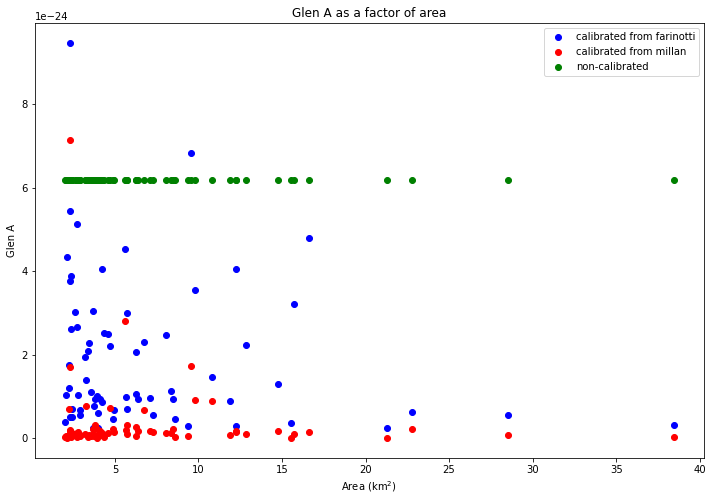

In [85]:
f, ax= plt.subplots(figsize=(12, 8))

plt.plot(x,new_diag_f,'bo',label='calibrated from farinotti')
plt.plot(x,new_diag_m,'ro',label='calibrated from millan')
plt.plot(x,new_diag_0,'go',label= 'non-calibrated')

plt.legend()          
plt.title('Glen A as a factor of area')
plt.xlabel('Area ($\mathregular{km^2}$)')
plt.ylabel('Glen A')
plt.legend()
name = 'Himalaya_glen-area.png'
plt.savefig(name, format = 'png')

### Estimates of error within calibration

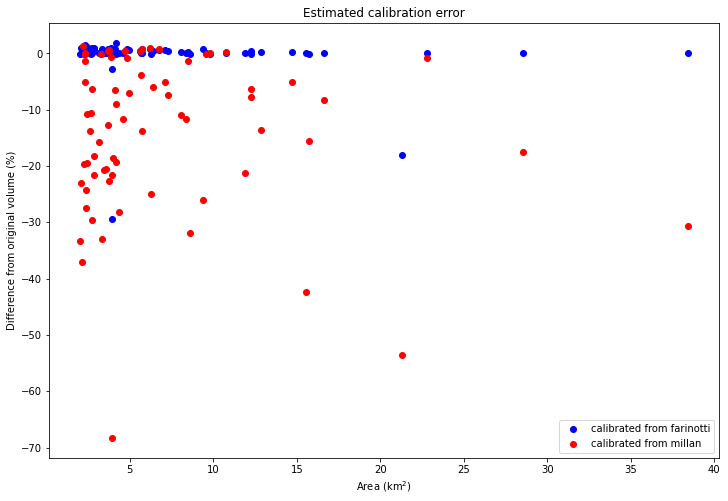

In [40]:
f, ax= plt.subplots(figsize=(12, 8))

plt.plot(x,new_diff,'bo',label='calibrated from farinotti')
plt.plot(x,new_difm,'ro',label='calibrated from millan')

plt.legend()          
plt.title('Estimated calibration error')
plt.xlabel('Area ($\mathregular{km^2}$)')
plt.ylabel('Difference from original volume (%)')
plt.legend()
name = 'Himalaya_estimates_vol.png'
plt.savefig(name, format = 'png')

## Running simulations based on the calibration

In [41]:
cfg.add_to_basenames('model_geometry_my_spinup','model_geometry_my_spinup.nc')
cfg.add_to_basenames('model_geometry_with_spinup','model_geometry_with_spinup.nc')
for rcp in ['rcp26','rcp45','rcp60','rcp85']:
    cfg.add_to_basenames('model_geometry_CCSM4_'+rcp+'','model_geometry_CCSM4_'+rcp+'.nc')
    cfg.add_to_basenames('model_diagnostics_CCSM4_'+rcp+'','model_diagnostics_CCSM4_'+rcp+'.nc')

In [42]:
cfg.add_to_basenames('model_geometry_no_spinup','model_geometry_no_spinup.nc')

In [43]:
#download and process gcm data
#precipitations
bp = 'https://cluster.klima.uni-bremen.de/~oggm/cmip5-ng/pr/pr_mon_CCSM4_{}_r1i1p1_g025.nc'
#temperatures
bt = 'https://cluster.klima.uni-bremen.de/~oggm/cmip5-ng/tas/tas_mon_CCSM4_{}_r1i1p1_g025.nc'

In [51]:
import work_tasks
from oggm.core import climate, massbalance, flowline

import time
# start time !
start_time = time.time()

cfg.PARAMS['store_model_geometry'] = True 

#Pre-allocate
out_evol={'oggm':[0]*4,'farinotti':[0]*4,'millan':[0]*4}
out_evol_no_spin = {'oggm':[0]*4,'farinotti':[0]*4,'millan':[0]*4}


out_hydro_hist = {'oggm':0,'farinotti':0,'millan':0}
out_hydro_hist_no_spin = {'oggm':0,'farinotti':0,'millan':0}


d_=[0,0,0]


k=0
data_list=['oggm','farinotti','millan']
for data in data_list:
    print(data)
    gdirs = workflow.init_glacier_directories(new_rgi,from_prepro_level=from_prepro_level,
                                                  prepro_border=prepro_border)
        
        
    for gdir in gdirs:
        #Calibration
        if (data=='farinotti'):
            workflow.calibrate_inversion_from_consensus(gdir,apply_fs_on_mismatch=True,error_on_mismatch=False)

        elif(data=='millan'):
            work_tasks.calibrate_inversion_from_millan(gdir,path_to_hdf,apply_fs_on_mismatch=True,error_on_mismatch=False)

        workflow.execute_entity_task(tasks.init_present_time_glacier, gdir)

            #Run the spinup simulation - t* climate    
    workflow.execute_entity_task(tasks.run_constant_climate, gdirs,nyears=200,output_filesuffix='_my_spinup') 

    utils.compile_glacier_statistics(gdirs)
    d_[k] = utils.compile_run_output(gdirs, input_filesuffix='_my_spinup')


            # Run a past climate run based on this spinup
    workflow.execute_entity_task(tasks.run_with_hydro, gdirs, run_task=tasks.run_from_climate_data,
                                        climate_filename='climate_historical',
                                        ys=2003, ye=2020,init_model_filesuffix='_my_spinup',
                                        output_filesuffix='_with_spinup',store_monthly_hydro=True)
            
    #dh=utils.compile_run_output(gdirs, input_filesuffix='_with_spinup') 

    #out_hydro_hist[data]=dh


    for rcp in ['rcp26', 'rcp45', 'rcp60', 'rcp85']:
            # read the path to the files, not opening with xr.opendataset()
        ft = utils.file_downloader(bt.format(rcp))
        fp = utils.file_downloader(bp.format(rcp))

            # bias correct them
        workflow.execute_entity_task(gcm_climate.process_cmip_data, gdirs, filesuffix='_CCSM4_{}'.format(rcp),             # recognize the climate file for later
                                             fpath_temp=ft,                                  # temperature projections
                                             fpath_precip=fp,                                # precip projections
                                             );  


        #projection run (starting from the end year of the historical run)
    for rcp in ['rcp26', 'rcp45', 'rcp60', 'rcp85']:
        rid = '_CCSM4_{}'.format(rcp)
            # with hydro                                
        workflow.execute_entity_task(tasks.run_with_hydro, gdirs, ys=2020,run_task=tasks.run_from_climate_data,
                                             climate_filename='gcm_data',                    # use gcm_data, not climate_historical
                                             climate_input_filesuffix=rid,                   # use the chosen scenario
                                             init_model_filesuffix='_with_spinup',             # this is important! Start from 2020 glacier
                                             output_filesuffix=rid,                          # recognize the run for later
                                             store_monthly_hydro=True,
                                            );

            # end of the run                                  
        print('Simulation finished sucessfully')

    r=0
    for rcp in ['rcp26', 'rcp45', 'rcp60', 'rcp85']:
        rid = '_CCSM4_{}'.format(rcp)

        dsf = utils.compile_run_output(gdirs, input_filesuffix=rid) 
            #for later plotting use
        out_evol[data][r]=dsf
        r+=1
        
    k+=1
    
print('Duration is')
print("--- %s seconds ---" % (time.time() - start_time)) 

oggm


2021-11-15 17:04:29: oggm.workflow: init_glacier_directories from prepro level 3 on 70 glaciers.
2021-11-15 17:04:29: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 70 glaciers
2021-11-15 17:04:34: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 17:04:34: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 17:04:34: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 17:04:34: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 17:04:34: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 17:04:34: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 17:04:34: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 17:04:34: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 17:04:34:

Simulation finished sucessfully


2021-11-15 17:08:23: oggm.workflow: Execute entity tasks [run_with_hydro] on 70 glaciers


Simulation finished sucessfully


2021-11-15 17:08:53: oggm.workflow: Execute entity tasks [run_with_hydro] on 70 glaciers


Simulation finished sucessfully


2021-11-15 17:09:22: oggm.utils: Applying global task compile_run_output on 70 glaciers
2021-11-15 17:09:22: oggm.utils: Applying compile_run_output on 70 gdirs.


Simulation finished sucessfully


2021-11-15 17:09:25: oggm.utils: Applying global task compile_run_output on 70 glaciers
2021-11-15 17:09:25: oggm.utils: Applying compile_run_output on 70 gdirs.
2021-11-15 17:09:27: oggm.utils: Applying global task compile_run_output on 70 glaciers
2021-11-15 17:09:27: oggm.utils: Applying compile_run_output on 70 gdirs.
2021-11-15 17:09:29: oggm.utils: Applying global task compile_run_output on 70 glaciers
2021-11-15 17:09:29: oggm.utils: Applying compile_run_output on 70 gdirs.


farinotti


2021-11-15 17:09:32: oggm.workflow: init_glacier_directories from prepro level 3 on 70 glaciers.
2021-11-15 17:09:32: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 70 glaciers
2021-11-15 17:09:36: oggm.workflow: Applying global task calibrate_inversion_from_consensus on 1 glaciers
2021-11-15 17:09:36: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-11-15 17:09:36: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:36: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:36: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:36: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:36: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:36: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-15 17:09:36: oggm.workflow: A

2021-11-15 17:09:37: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:37: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:37: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:37: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:37: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:37: oggm.workflow: Consensus estimate optimisation with A factor: 0.8570332969333403 and fs: 0
2021-11-15 17:09:37: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:37: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:37: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:37: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:37: oggm.workflow

2021-11-15 17:09:37: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:37: oggm.workflow: calibrate_inversion_from_consensus converged after 7 iterations and fs=0. The resulting Glen A factor is 2.004599542229728.
2021-11-15 17:09:37: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:37: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:37: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:37: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:37: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:37: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 17:09:37: oggm.workflow: Applying global task calibrate_inversion_from_consensus on 1 glaciers
2021-11-15 17:09:37: oggm.workflow: Consensus estimate optimisation

2021-11-15 17:09:38: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:38: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:38: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:38: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:38: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:38: oggm.workflow: Consensus estimate optimisation with A factor: 3.2790616336268616 and fs: 0
2021-11-15 17:09:38: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:38: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:38: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:38: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:38: oggm.workflow

2021-11-15 17:09:38: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:38: oggm.workflow: Consensus estimate optimisation with A factor: 1.0703347061852644 and fs: 0
2021-11-15 17:09:38: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:38: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:38: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:38: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:38: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:38: oggm.workflow: Consensus estimate optimisation with A factor: 1.0953791515684392 and fs: 0
2021-11-15 17:09:38: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:38: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:38: oggm.

2021-11-15 17:09:38: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:38: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:38: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:38: oggm.workflow: calibrate_inversion_from_consensus converged after 8 iterations and fs=0. The resulting Glen A factor is 1.1069218600213424.
2021-11-15 17:09:38: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:38: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:38: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:38: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:38: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:38: oggm.workflow: Execute entity tasks [init_present_ti

2021-11-15 17:09:39: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:39: oggm.workflow: Consensus estimate optimisation with A factor: 3.5420713714867276 and fs: 0
2021-11-15 17:09:39: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:39: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:39: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:39: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:39: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:39: oggm.workflow: Consensus estimate optimisation with A factor: 1.8210356857433638 and fs: 0
2021-11-15 17:09:39: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:39: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:39: oggm.

2021-11-15 17:09:39: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:39: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:39: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:39: oggm.workflow: calibrate_inversion_from_consensus converged after 7 iterations and fs=0. The resulting Glen A factor is 2.135213052842139.
2021-11-15 17:09:39: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:39: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:39: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:39: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:39: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:39: oggm.workflow: Execute entity tasks [init_present_tim

2021-11-15 17:09:40: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:40: oggm.workflow: Consensus estimate optimisation with A factor: 3.401784193541867 and fs: 0
2021-11-15 17:09:40: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:40: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:40: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:40: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:40: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:40: oggm.workflow: Consensus estimate optimisation with A factor: 1.7508920967709336 and fs: 0
2021-11-15 17:09:40: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:40: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:40: oggm.w

2021-11-15 17:09:41: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:41: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:41: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:41: oggm.workflow: Consensus estimate optimisation with A factor: 1.0502648237569083 and fs: 0
2021-11-15 17:09:41: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:41: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:41: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:41: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:41: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:41: oggm.workflow: Consensus estimate optimisation with A factor: 1.0447888648282266 and fs: 0
2021-11-15

2021-11-15 17:09:42: oggm.workflow: Applying global task calibrate_inversion_from_consensus on 1 glaciers
2021-11-15 17:09:42: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-11-15 17:09:42: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:42: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:42: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:42: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:42: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:42: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-15 17:09:42: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:42: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:42: oggm.workflow: Execute

2021-11-15 17:09:43: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:43: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:43: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:43: oggm.workflow: Consensus estimate optimisation with A factor: 1.7810668154203493 and fs: 0
2021-11-15 17:09:43: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:43: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:43: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:43: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:43: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:43: oggm.workflow: Consensus estimate optimisation with A factor: 1.477930569161536 and fs: 0
2021-11-15 

2021-11-15 17:09:43: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:43: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:43: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:43: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:43: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:43: oggm.workflow: calibrate_inversion_from_consensus converged after 8 iterations and fs=0. The resulting Glen A factor is 1.2673036994197169.
2021-11-15 17:09:43: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:43: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:43: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:43: oggm.workflow: Execute entity tasks [filter_inversion_output]

2021-11-15 17:09:45: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:45: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:45: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:45: oggm.workflow: Consensus estimate optimisation with A factor: 2.6779491219124223 and fs: 0
2021-11-15 17:09:45: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:45: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:45: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:45: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:45: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:45: oggm.workflow: Consensus estimate optimisation with A factor: 0.9388098258397457 and fs: 0
2021-11-15

2021-11-15 17:09:45: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:45: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:45: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:45: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:45: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:45: oggm.workflow: Consensus estimate optimisation with A factor: 0.5506924644560713 and fs: 0
2021-11-15 17:09:45: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:45: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:45: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:45: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:45: oggm.workflow

2021-11-15 17:09:46: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:46: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:46: oggm.workflow: Consensus estimate optimisation with A factor: 0.9456834528138567 and fs: 0
2021-11-15 17:09:46: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:46: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:46: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:46: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:46: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:46: oggm.workflow: Consensus estimate optimisation with A factor: 0.2206264417938787 and fs: 0
2021-11-15 17:09:46: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:46: ogg

2021-11-15 17:09:47: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:47: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:47: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:47: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:47: oggm.workflow: Consensus estimate optimisation with A factor: 0.3010544444357295 and fs: 0
2021-11-15 17:09:47: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:47: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:47: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:47: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:47: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:47: oggm.w

2021-11-15 17:09:48: oggm.workflow: Consensus estimate optimisation with A factor: 0.43022981683197353 and fs: 0
2021-11-15 17:09:48: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:48: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:48: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:48: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:48: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:48: oggm.workflow: calibrate_inversion_from_consensus converged after 9 iterations and fs=0. The resulting Glen A factor is 0.43022981683197353.
2021-11-15 17:09:48: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:48: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:48: oggm.workflow: Execute entity tasks [mass_conser

2021-11-15 17:09:48: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:48: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:48: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:48: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:48: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:48: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-15 17:09:48: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:48: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:48: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:48: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:48: oggm.workflow: Execute enti

2021-11-15 17:09:49: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:49: oggm.workflow: Consensus estimate optimisation with A factor: 0.2360357417827491 and fs: 0
2021-11-15 17:09:49: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:49: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:49: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:49: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:49: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:49: oggm.workflow: Consensus estimate optimisation with A factor: 0.19392762622169957 and fs: 0
2021-11-15 17:09:49: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:49: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:49: oggm

2021-11-15 17:09:49: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:49: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:49: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:49: oggm.workflow: calibrate_inversion_from_consensus converged after 8 iterations and fs=0. The resulting Glen A factor is 0.2285468370058209.
2021-11-15 17:09:49: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:49: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:49: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:49: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:49: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:49: oggm.workflow: Execute entity tasks [init_present_ti

2021-11-15 17:09:49: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:49: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-15 17:09:49: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:49: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:49: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:49: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:49: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:49: oggm.workflow: Consensus estimate optimisation with A factor: 8.130119043872014 and fs: 0
2021-11-15 17:09:49: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:49: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:49: oggm.workflow: Execu

2021-11-15 17:09:50: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:50: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:50: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:50: oggm.workflow: Consensus estimate optimisation with A factor: 0.46380610464989747 and fs: 0
2021-11-15 17:09:50: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:50: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:50: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:50: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:50: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:50: oggm.workflow: Consensus estimate optimisation with A factor: 0.2442989639340637 and fs: 0
2021-11-1

2021-11-15 17:09:50: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:50: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:50: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:50: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:50: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:50: oggm.workflow: Consensus estimate optimisation with A factor: 0.21483420896871794 and fs: 0
2021-11-15 17:09:50: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:50: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:50: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:50: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:50: oggm.workflo

2021-11-15 17:09:50: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:50: oggm.workflow: calibrate_inversion_from_consensus converged after 9 iterations and fs=0. The resulting Glen A factor is 0.2856225237326937.
2021-11-15 17:09:50: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:50: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:50: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:50: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:50: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:50: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 17:09:50: oggm.workflow: Applying global task calibrate_inversion_from_consensus on 1 glaciers
2021-11-15 17:09:51: oggm.workflow: Consensus estimate optimisatio

2021-11-15 17:09:51: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:51: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:51: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:51: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:51: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:51: oggm.workflow: Consensus estimate optimisation with A factor: 0.8944607664827989 and fs: 0
2021-11-15 17:09:51: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:51: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:51: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:51: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:51: oggm.workflow

2021-11-15 17:09:51: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:51: oggm.workflow: Consensus estimate optimisation with A factor: 0.1873590544633629 and fs: 0
2021-11-15 17:09:51: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:51: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:51: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:52: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:52: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:52: oggm.workflow: Consensus estimate optimisation with A factor: 0.19063350325122042 and fs: 0
2021-11-15 17:09:52: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:52: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:52: oggm

2021-11-15 17:09:52: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:52: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:52: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:52: oggm.workflow: calibrate_inversion_from_consensus converged after 9 iterations and fs=0. The resulting Glen A factor is 0.2952254440613181.
2021-11-15 17:09:52: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:52: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:52: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:52: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:52: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:52: oggm.workflow: Execute entity tasks [init_present_ti

2021-11-15 17:09:53: oggm.workflow: Consensus estimate optimisation with A factor: 0.21115035617328545 and fs: 0
2021-11-15 17:09:53: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:53: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:53: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:53: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:53: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:53: oggm.workflow: Consensus estimate optimisation with A factor: 0.21009460439141903 and fs: 0
2021-11-15 17:09:53: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:53: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:53: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:

2021-11-15 17:09:54: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:54: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:54: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:54: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:54: oggm.workflow: Consensus estimate optimisation with A factor: 3.1245699904328808 and fs: 0
2021-11-15 17:09:54: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:54: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:54: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:54: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:54: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:54: oggm.w

2021-11-15 17:09:55: oggm.workflow: Consensus estimate optimisation with A factor: 0.9702667747826231 and fs: 0
2021-11-15 17:09:55: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:55: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:55: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:55: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:55: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:55: oggm.workflow: Consensus estimate optimisation with A factor: 0.931803258739245 and fs: 0
2021-11-15 17:09:55: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:55: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:55: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:55:

2021-11-15 17:09:56: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:56: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:56: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 17:09:56: oggm.workflow: Applying global task calibrate_inversion_from_consensus on 1 glaciers
2021-11-15 17:09:56: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-11-15 17:09:56: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:56: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:56: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:56: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:56: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:56: oggm.workflo

2021-11-15 17:09:57: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:57: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:57: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:57: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:57: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:57: oggm.workflow: calibrate_inversion_from_consensus converged after 8 iterations and fs=0. The resulting Glen A factor is 0.7325669293177305.
2021-11-15 17:09:57: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:57: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:57: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:57: oggm.workflow: Execute entity tasks [filter_inversion_output]

2021-11-15 17:09:58: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:58: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:58: oggm.workflow: calibrate_inversion_from_consensus converged after 6 iterations and fs=0. The resulting Glen A factor is 3.9472637643996005.
2021-11-15 17:09:58: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:58: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:58: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:58: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:58: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:58: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 17:09:58: oggm.workflow: Applying global task calibrate_inversio

2021-11-15 17:09:59: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-15 17:09:59: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:59: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:59: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:59: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:09:59: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:09:59: oggm.workflow: Consensus estimate optimisation with A factor: 2.770849782072909 and fs: 0
2021-11-15 17:09:59: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:09:59: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:09:59: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:09:59: oggm.workflow

2021-11-15 17:10:00: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:10:00: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:10:00: oggm.workflow: Consensus estimate optimisation with A factor: 1.2897652968659141 and fs: 0
2021-11-15 17:10:00: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:10:00: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:10:00: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:10:00: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:10:00: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:10:00: oggm.workflow: Consensus estimate optimisation with A factor: 0.6948826484329571 and fs: 0
2021-11-15 17:10:00: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:10:00: ogg

2021-11-15 17:10:00: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:10:00: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:10:00: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:10:01: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:10:01: oggm.workflow: Consensus estimate optimisation with A factor: 0.4043403793185974 and fs: 0
2021-11-15 17:10:01: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:10:01: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:10:01: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:10:01: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:10:01: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:10:01: oggm.w

2021-11-15 17:10:01: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 17:10:01: oggm.workflow: Applying global task calibrate_inversion_from_consensus on 1 glaciers
2021-11-15 17:10:01: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-11-15 17:10:01: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:10:01: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:10:01: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:10:01: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:10:01: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:10:01: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-15 17:10:01: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:10:01: oggm.workflow: Exe

2021-11-15 17:10:01: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:10:01: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:10:01: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:10:01: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:10:01: oggm.workflow: Consensus estimate optimisation with A factor: 1.604521049564695 and fs: 0
2021-11-15 17:10:01: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:10:01: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:10:01: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:10:01: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:10:01: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:10:01: oggm.wo

2021-11-15 17:10:02: oggm.workflow: Consensus estimate optimisation with A factor: 0.723970383690644 and fs: 0
2021-11-15 17:10:02: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:10:02: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:10:02: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:10:02: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:10:02: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:10:02: oggm.workflow: Consensus estimate optimisation with A factor: 0.4776596137051274 and fs: 0
2021-11-15 17:10:02: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:10:02: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:10:02: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:10:02:

2021-11-15 17:10:02: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:10:02: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:10:02: oggm.workflow: Consensus estimate optimisation with A factor: 0.39545207823453354 and fs: 0
2021-11-15 17:10:02: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:10:02: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:10:02: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:10:02: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:10:02: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:10:02: oggm.workflow: Consensus estimate optimisation with A factor: 0.3934748178423609 and fs: 0
2021-11-15 17:10:02: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:10:02: og

2021-11-15 17:10:02: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:10:02: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:10:02: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:10:02: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:10:02: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:10:02: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 17:10:02: oggm.workflow: Applying global task calibrate_inversion_from_consensus on 1 glaciers
2021-11-15 17:10:03: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-11-15 17:10:03: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:10:03: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:10:03: oggm.workflow: Execut

2021-11-15 17:10:03: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:10:03: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:10:03: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:10:03: oggm.workflow: Consensus estimate optimisation with A factor: 4.018943165392805 and fs: 0
2021-11-15 17:10:03: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:10:03: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:10:03: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:10:03: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:10:03: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:10:03: oggm.workflow: Consensus estimate optimisation with A factor: 1.8937906260471824 and fs: 0
2021-11-15 

2021-11-15 17:10:03: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:10:03: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:10:03: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:10:03: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:10:03: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:10:03: oggm.workflow: Consensus estimate optimisation with A factor: 1.3523832978896368 and fs: 0
2021-11-15 17:10:03: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:10:03: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:10:03: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:10:03: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:10:03: oggm.workflow

2021-11-15 17:10:04: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:10:04: oggm.workflow: Consensus estimate optimisation with A factor: 0.12160560541862099 and fs: 0
2021-11-15 17:10:04: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:10:04: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:10:04: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:10:04: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:10:04: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:10:04: oggm.workflow: calibrate_inversion_from_consensus converged after 6 iterations and fs=0. The resulting Glen A factor is 0.12160560541862099.
2021-11-15 17:10:04: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:10:04: oggm.workflow: Execute entity tasks [prepare_for_

2021-11-15 17:10:05: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:10:05: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:10:05: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:10:05: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:10:05: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:10:05: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-15 17:10:05: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:10:05: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:10:05: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:10:05: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:10:05: oggm.workflow: Execute enti

2021-11-15 17:10:06: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:10:06: oggm.workflow: Consensus estimate optimisation with A factor: 2.0842387555347512 and fs: 0
2021-11-15 17:10:06: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:10:06: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:10:06: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:10:06: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:10:06: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:10:06: oggm.workflow: Consensus estimate optimisation with A factor: 1.2229159511442638 and fs: 0
2021-11-15 17:10:06: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:10:06: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:10:06: oggm.

2021-11-15 17:10:07: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:10:07: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:10:07: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:10:07: oggm.workflow: Consensus estimate optimisation with A factor: 0.8184681025033431 and fs: 0
2021-11-15 17:10:07: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:10:07: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:10:07: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:10:07: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:10:07: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:10:07: oggm.workflow: Consensus estimate optimisation with A factor: 0.8139376815934481 and fs: 0
2021-11-15

2021-11-15 17:10:07: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:10:07: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:10:07: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:10:07: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:10:07: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:10:07: oggm.workflow: calibrate_inversion_from_consensus converged after 9 iterations and fs=0. The resulting Glen A factor is 0.4595946935121351.
2021-11-15 17:10:07: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:10:07: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:10:07: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:10:07: oggm.workflow: Execute entity tasks [filter_inversion_output]

2021-11-15 17:10:09: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:10:09: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:10:09: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:10:09: oggm.workflow: Consensus estimate optimisation with A factor: 3.906830601784371 and fs: 0
2021-11-15 17:10:09: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:10:09: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:10:09: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:10:09: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:10:09: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:10:09: oggm.workflow: Consensus estimate optimisation with A factor: 2.0034153008921853 and fs: 0
2021-11-15 

2021-11-15 17:10:09: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:10:09: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:10:09: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:10:09: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:10:09: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:10:09: oggm.workflow: Consensus estimate optimisation with A factor: 0.9483345640998657 and fs: 0
2021-11-15 17:10:09: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:10:09: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:10:09: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:10:09: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:10:09: oggm.workflow

2021-11-15 17:10:10: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:10:10: oggm.workflow: Consensus estimate optimisation with A factor: 0.22859426114498518 and fs: 0
2021-11-15 17:10:10: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:10:10: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:10:10: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:10:10: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:10:10: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:10:10: oggm.workflow: calibrate_inversion_from_consensus converged after 9 iterations and fs=0. The resulting Glen A factor is 0.22974297602611576.
2021-11-15 17:10:10: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:10:10: oggm.workflow: Execute entity tasks [prepare_for_

Simulation finished sucessfully


2021-11-15 17:14:03: oggm.workflow: Execute entity tasks [run_with_hydro] on 70 glaciers


Simulation finished sucessfully


2021-11-15 17:14:32: oggm.workflow: Execute entity tasks [run_with_hydro] on 70 glaciers


Simulation finished sucessfully


2021-11-15 17:15:03: oggm.utils: Applying global task compile_run_output on 70 glaciers
2021-11-15 17:15:03: oggm.utils: Applying compile_run_output on 70 gdirs.


Simulation finished sucessfully


2021-11-15 17:15:05: oggm.utils: Applying global task compile_run_output on 70 glaciers
2021-11-15 17:15:05: oggm.utils: Applying compile_run_output on 70 gdirs.
2021-11-15 17:15:08: oggm.utils: Applying global task compile_run_output on 70 glaciers
2021-11-15 17:15:08: oggm.utils: Applying compile_run_output on 70 gdirs.
2021-11-15 17:15:10: oggm.utils: Applying global task compile_run_output on 70 glaciers
2021-11-15 17:15:10: oggm.utils: Applying compile_run_output on 70 gdirs.


millan


2021-11-15 17:15:13: oggm.workflow: init_glacier_directories from prepro level 3 on 70 glaciers.
2021-11-15 17:15:13: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 70 glaciers
2021-11-15 17:15:17: work_tasks: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-11-15 17:15:17: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:17: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:17: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:17: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:15:17: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:15:17: work_tasks: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-15 17:15:17: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:17: oggm.workflow: Execute entity tasks [prep

2021-11-15 17:15:17: work_tasks: We use A factor = 0.1 and fs = 0 and move on.
2021-11-15 17:15:17: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:17: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:17: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:17: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:15:17: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:15:17: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 17:15:17: work_tasks: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-11-15 17:15:17: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:17: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:17: oggm.workflow: Execute entity tasks [mass_conservat

2021-11-15 17:15:17: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:17: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:17: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:15:17: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:15:17: work_tasks: calibration from millan estimate CAN'T converge with fs=0.
Bound values (km3):
Ref=0.189 OGGM=0.140 for A factor 0.1
Ref=0.189 OGGM=0.061 for A factor 10
2021-11-15 17:15:17: work_tasks: We use A factor = 0.1 and fs = 0 and move on.
2021-11-15 17:15:17: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:17: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:17: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:17: oggm.workflow: Execute entity tasks [filter

2021-11-15 17:15:17: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:17: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:17: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:17: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:15:17: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:15:17: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:17: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:17: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:17: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:15:17: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:15:17: work_tasks: calibration from mi

2021-11-15 17:15:18: work_tasks: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-15 17:15:18: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Execute entity 

2021-11-15 17:15:18: work_tasks: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-11-15 17:15:18: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:15:18: work_tasks: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-15 17:15:18: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Execute entity tas

2021-11-15 17:15:18: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 17:15:18: work_tasks: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-11-15 17:15:18: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Execute entity

2021-11-15 17:15:18: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:15:18: work_tasks: calibration from millan estimate CAN'T converge with fs=0.
Bound values (km3):
Ref=1.858 OGGM=1.463 for A factor 0.1
Ref=1.858 OGGM=0.589 for A factor 10
2021-11-15 17:15:18: work_tasks: We use A factor = 0.1 and fs = 0 and move on.
2021-11-15 17:15:18: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Execute entity tasks [get_

2021-11-15 17:15:18: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:15:18: work_tasks: calibration from millan estimate CAN'T converge with fs=0.
Bound values (km3):
Ref=0.266 OGGM=0.207 for A 

2021-11-15 17:15:18: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Applying global 

2021-11-15 17:15:18: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:15:18: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:15:19: work_tasks: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-15 17:15:19: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:19: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:19: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:19: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:15:19: oggm.workflow: Execute entity 

2021-11-15 17:15:19: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:19: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:19: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:19: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:15:19: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:15:19: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 17:15:19: work_tasks: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-11-15 17:15:19: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:19: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:19: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:19: oggm.workflow: Execute entity

2021-11-15 17:15:19: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:19: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:15:19: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:15:19: work_tasks: calibration from millan estimate CAN'T converge with fs=0.
Bound values (km3):
Ref=0.355 OGGM=0.328 for A factor 0.1
Ref=0.355 OGGM=0.132 for A factor 10
2021-11-15 17:15:19: work_tasks: We use A factor = 0.1 and fs = 0 and move on.
2021-11-15 17:15:19: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:19: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:19: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:19: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:15:19: oggm.workflow: Execute entity tasks [get_

2021-11-15 17:15:19: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:19: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:19: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:15:19: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:15:19: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:19: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:19: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:19: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:15:19: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:15:19: work_tasks: calibration from millan estimate CAN'T converge with fs=0.
Bound values (km3):
Ref=0.284 OGGM=0.279 for A 

2021-11-15 17:15:19: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:19: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:19: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:19: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:15:19: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:15:19: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:19: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:19: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:19: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:15:19: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:15:19: work_tasks: calibration from mi

2021-11-15 17:15:19: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:19: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:19: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:19: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:15:19: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:15:19: work_tasks: Consensus estimate optimisation with A factor: 1.184927158948059 and fs: 0
2021-11-15 17:15:19: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:19: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:19: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:19: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:15:19: oggm.workflow: Ex

2021-11-15 17:15:19: work_tasks: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-11-15 17:15:19: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:19: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:19: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:19: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:15:19: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:15:19: work_tasks: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-15 17:15:19: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:19: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:19: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:19: oggm.workflow: Execute entity tas

2021-11-15 17:15:20: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:20: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:20: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:15:20: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:15:20: work_tasks: calibration from millan estimate CAN'T converge with fs=0.
Bound values (km3):
Ref=0.647 OGGM=0.205 for A factor 0.1
Ref=0.647 OGGM=0.083 for A factor 10
2021-11-15 17:15:20: work_tasks: We use A factor = 0.1 and fs = 0 and move on.
2021-11-15 17:15:20: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:20: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:20: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:20: oggm.workflow: Execute entity tasks [filter

2021-11-15 17:15:20: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:15:20: work_tasks: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-15 17:15:20: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:20: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:20: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:20: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:15:20: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:15:20: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:20: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:20: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:20: oggm.workflow: Execute entity tas

2021-11-15 17:15:20: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:15:20: work_tasks: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-15 17:15:20: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:20: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:20: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:20: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:15:20: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:15:20: work_tasks: Consensus estimate optimisation with A factor: 3.5586905910265014 and fs: 0
2021-11-15 17:15:20: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:20: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:20: oggm.workflow: Execute en

2021-11-15 17:15:20: work_tasks: We use A factor = 0.1 and fs = 0 and move on.
2021-11-15 17:15:20: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:20: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:20: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:20: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:15:20: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:15:20: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 17:15:20: work_tasks: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-11-15 17:15:20: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:20: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:20: oggm.workflow: Execute entity tasks [mass_conservat

2021-11-15 17:15:20: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:15:20: work_tasks: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-15 17:15:20: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:20: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:20: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:20: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:15:20: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:15:20: work_tasks: Consensus estimate optimisation with A factor: 3.125643743786521 and fs: 0
2021-11-15 17:15:20: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:20: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:20: oggm.workflow: Execute ent

2021-11-15 17:15:21: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:15:21: work_tasks: Consensus estimate optimisation with A factor: 0.1572699009551789 and fs: 0
2021-11-15 17:15:21: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:21: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:21: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:21: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:15:21: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:15:21: work_tasks: Consensus estimate optimisation with A factor: 0.13995929581426067 and fs: 0
2021-11-15 17:15:21: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:21: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:21: oggm.workf

2021-11-15 17:15:21: work_tasks: We use A factor = 0.1 and fs = 0 and move on.
2021-11-15 17:15:21: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:21: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:21: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:21: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:15:21: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:15:21: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 17:15:21: work_tasks: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-11-15 17:15:21: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:21: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:21: oggm.workflow: Execute entity tasks [mass_conservat

2021-11-15 17:15:21: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:21: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:21: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:15:21: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:15:21: work_tasks: calibration from millan estimate CAN'T converge with fs=0.
Bound values (km3):
Ref=0.164 OGGM=0.152 for A factor 0.1
Ref=0.164 OGGM=0.062 for A factor 10
2021-11-15 17:15:21: work_tasks: We use A factor = 0.1 and fs = 0 and move on.
2021-11-15 17:15:21: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:21: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:21: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:21: oggm.workflow: Execute entity tasks [filter

2021-11-15 17:15:22: work_tasks: Consensus estimate optimisation with A factor: 0.3913792007288442 and fs: 0
2021-11-15 17:15:22: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:22: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:22: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:22: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:15:22: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:15:22: work_tasks: Consensus estimate optimisation with A factor: 0.378721199572293 and fs: 0
2021-11-15 17:15:22: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:22: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:22: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:22: oggm.

2021-11-15 17:15:22: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 17:15:22: work_tasks: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-11-15 17:15:22: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:22: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:22: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:22: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:15:22: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:15:22: work_tasks: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-11-15 17:15:22: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:22: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:22: oggm.workflow: Execute entity tasks

2021-11-15 17:15:22: work_tasks: We use A factor = 0.1 and fs = 0 and move on.
2021-11-15 17:15:22: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:22: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:22: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:22: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:15:22: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:15:22: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2021-11-15 17:15:22: work_tasks: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-11-15 17:15:22: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:22: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:22: oggm.workflow: Execute entity tasks [mass_conservat

2021-11-15 17:15:23: work_tasks: Consensus estimate optimisation with A factor: 2.758207839521654 and fs: 0
2021-11-15 17:15:23: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:23: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:23: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:23: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:15:23: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:15:23: work_tasks: Consensus estimate optimisation with A factor: 1.429103919760827 and fs: 0
2021-11-15 17:15:23: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:23: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:23: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:23: oggm.w

2021-11-15 17:15:23: work_tasks: Consensus estimate optimisation with A factor: 0.31708700103270043 and fs: 0
2021-11-15 17:15:23: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:23: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:23: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:23: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-11-15 17:15:23: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-11-15 17:15:23: work_tasks: Consensus estimate optimisation with A factor: 0.30676157096425655 and fs: 0
2021-11-15 17:15:23: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-11-15 17:15:23: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-11-15 17:15:23: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-11-15 17:15:23: og

Simulation finished sucessfully


2021-11-15 17:19:16: oggm.workflow: Execute entity tasks [run_with_hydro] on 70 glaciers


Simulation finished sucessfully


2021-11-15 17:19:46: oggm.workflow: Execute entity tasks [run_with_hydro] on 70 glaciers


Simulation finished sucessfully


2021-11-15 17:20:16: oggm.utils: Applying global task compile_run_output on 70 glaciers
2021-11-15 17:20:16: oggm.utils: Applying compile_run_output on 70 gdirs.


Simulation finished sucessfully


2021-11-15 17:20:18: oggm.utils: Applying global task compile_run_output on 70 glaciers
2021-11-15 17:20:18: oggm.utils: Applying compile_run_output on 70 gdirs.
2021-11-15 17:20:21: oggm.utils: Applying global task compile_run_output on 70 glaciers
2021-11-15 17:20:21: oggm.utils: Applying compile_run_output on 70 gdirs.
2021-11-15 17:20:23: oggm.utils: Applying global task compile_run_output on 70 glaciers
2021-11-15 17:20:23: oggm.utils: Applying compile_run_output on 70 gdirs.


Duration is
--- 956.1205525398254 seconds ---


# Figures

## Influence of the spin up

If the glen parameter A is well adjusted, the spin up shouldn't change much the initial volume

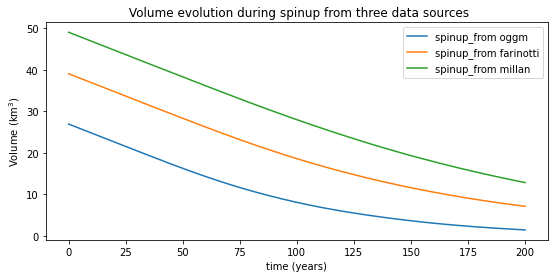

In [53]:
f, ax = plt.subplots(figsize=(9, 4))
for k in range(0,3):
    (d_[k].volume.sum(dim='rgi_id') * 1e-9).plot(ax=ax, label='spinup_from '+data_list[k])

plt.legend()
plt.title(' Volume evolution during spinup from three data sources')
plt.xlabel('time (years)')
plt.ylabel('Volume ($\mathregular{km^3}$)')
name = 'set_himalaya_volume_spinup.png'
plt.savefig(name, format = 'png')

## Projected volume evolution for several RCP scenarios

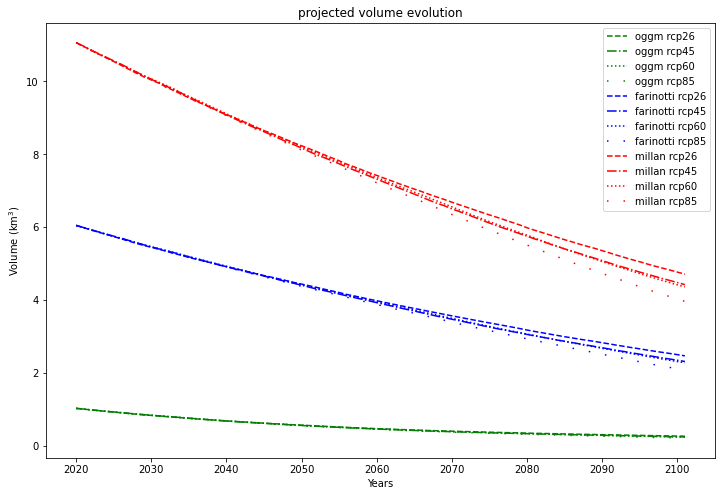

In [55]:
f, ax= plt.subplots(figsize=(12, 8))
rcp=['rcp26','rcp45','rcp60','rcp85']


for data in data_list:
    if (data=='farinotti'):
        color_s="b"
    elif(data=='millan'):
        color_s="r"
    else:
        color_s="g"

    #(out_hydro_hist[data].volume_m3*10**-9).plot(ax=ax,label=''+data+' historical', linestyle='-',color=color_s)
    for k in range(0,4):
        if (k==0):
            st='dashed'
        elif (k==1):
            st='-.'
        elif (k==2):
            st=':'
        else:
            st=(0, (1, 10))
            
        (out_evol[data][k].sum(dim='rgi_id').volume*10**-9).plot(ax=ax,label=''+data+' '+rcp[k]+'', linestyle=st,color=color_s)

                    
plt.legend()          
plt.title('projected volume evolution')
plt.xlabel('Years')
plt.ylabel('Volume ($\mathregular{km^3}$)')
name = 'set_himalaya_evol_volume_all.png'
plt.savefig(name, format = 'png')

## Projected area evolution for several RCP scenarios

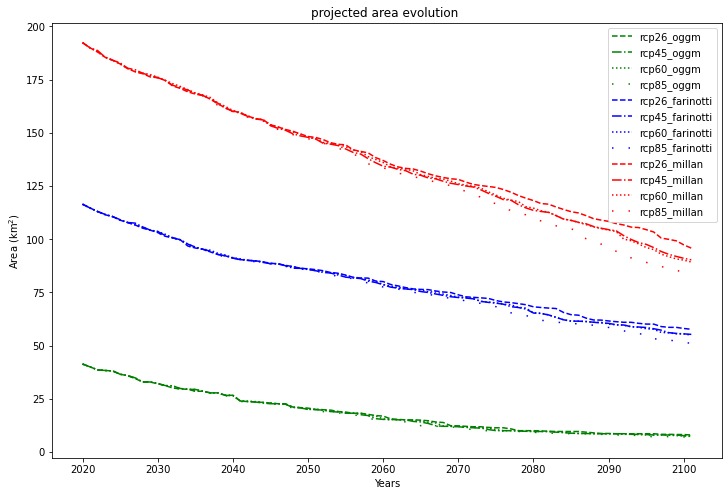

In [56]:
f, ax= plt.subplots(figsize=(12, 8))
rcp=['rcp26','rcp45','rcp60','rcp85']


for data in data_list:
    if (data=='farinotti'):
        color_s="b"
    elif(data=='millan'):
        color_s="r"
    else:
        color_s="g"
        
    #(out_hydro_hist[data].area_m2*10**-6).plot(ax=ax,label=''+data+' historical', linestyle='-',color=color_s)
    for k in range(0,4):
        if (k==0):
            st='dashed'
        elif (k==1):
            st='-.'
        elif (k==2):
            st=':'
        else:
            st=(0, (1, 10))
            
        (out_evol[data][k].sum(dim='rgi_id').area*10**-6).plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle=st,color=color_s)
        

plt.legend()          
plt.title('projected area evolution ')
plt.xlabel('Years')
plt.ylabel('Area ($\mathregular{km^2}$)')
name = 'set_himalaya_evol_area_all.png'
plt.savefig(name, format = 'png')

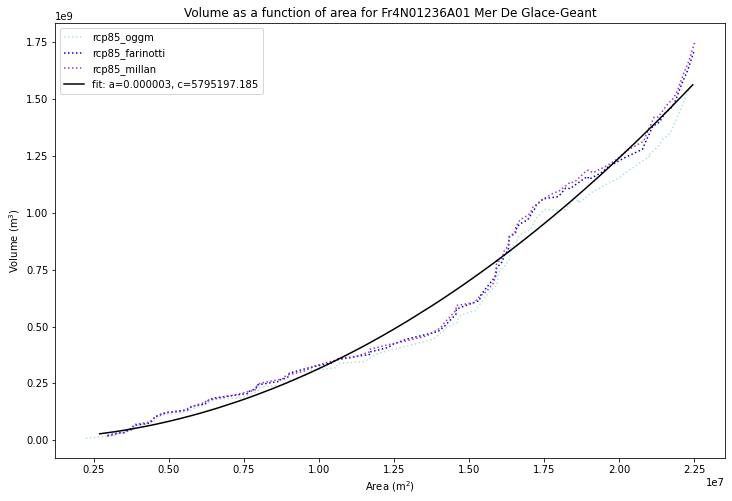

In [281]:
f, ax= plt.subplots(figsize=(12, 8))
rcp=['rcp26','rcp45','rcp60','rcp85']
from scipy.optimize import curve_fit


def func(x, a, c):

    return a * x**2 + c

x_data=[]
y_data=[]
for data in data_list:
    if (data=='farinotti'):
        plt.plot(out_evol[data][3].area,out_evol[data][3].volume,label=''+rcp[3]+'_'+data, linestyle=":",color="mediumblue")
    elif (data=='millan'):
        plt.plot(out_evol[data][3].area,out_evol[data][3].volume,label=''+rcp[3]+'_'+data, linestyle=":",color="darkorchid")
    else:
        plt.plot(out_evol[data][3].area,out_evol[data][3].volume,label=''+rcp[3]+'_'+data, linestyle=":",color="powderblue")

    x_data.append(out_evol[data][3].sum(dim='rgi_id').area)
    y_data.append(out_evol[data][3].sum(dim='rgi_id').volume)
    
x_data=(x_data[0]+x_data[1]+x_data[2])/3
y_data=(y_data[0]+y_data[1]+y_data[2])/3

popt, pcov = curve_fit(func, x_data, y_data)
plt.plot(x_data,func(x_data,*popt),c="k",label='fit: a=%5.6f, c=%5.3f' % tuple(popt))


plt.xlabel('Area ($\mathregular{m^2}$)')
plt.ylabel('Volume ($\mathregular{m^3}$)')
plt.legend()          
plt.title('Volume as a function of area for '+gdir.name_corr+'')
name = ''+gdir.name_corr+'_evol_ratio_opt1.png'
plt.savefig(name, format = 'png')

## Projected area evolution for several RCP scenarios

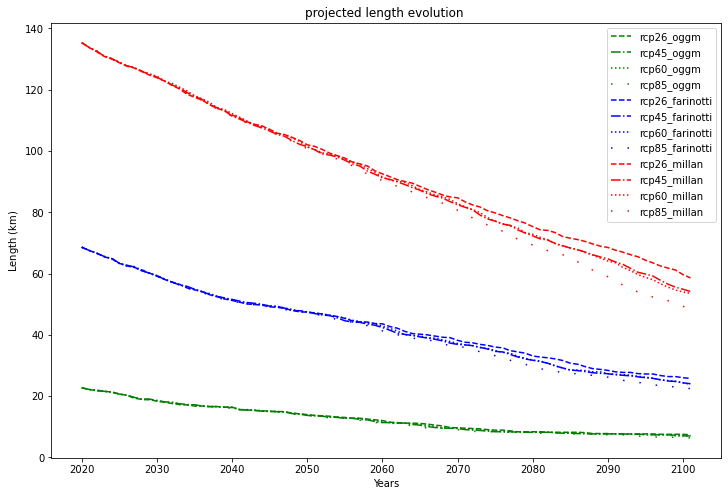

In [57]:
f, ax= plt.subplots(figsize=(12, 8))
rcp=['rcp26','rcp45','rcp60','rcp85']


for data in data_list:
    if (data=='farinotti'):
        color_s="b"
    elif(data=='millan'):
        color_s="r"
    else:
        color_s="g"
        
    #(out_hydro_hist[data].length_m*10**-3).plot(ax=ax,label=''+data+' historical', linestyle='-',color=color_s)
    for k in range(0,4):
        if (k==0):
            st='dashed'
        elif (k==1):
            st='-.'
        elif (k==2):
            st=':'
        else:
            st=(0, (1, 10))
            
        (out_evol[data][k].sum(dim='rgi_id').length*10**-3).plot(ax=ax,label=''+rcp[k]+'_'+data, linestyle=st,color=color_s)
        

plt.legend()          
plt.title('projected length evolution ')
plt.xlabel('Years')
plt.ylabel('Length ($\mathregular{km}$)')
name = 'set_himalaya_evol_length_all.png'
plt.savefig(name, format = 'png')


## Annual runoff and peak water 

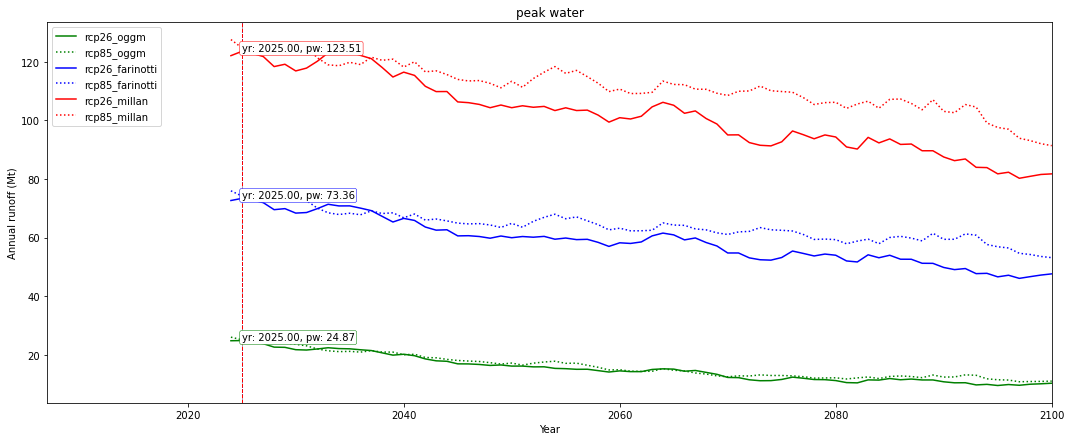

In [60]:
f, ax = plt.subplots(figsize=(18, 7))
rcp=['rcp26','rcp45','rcp60','rcp85']

                
for data in data_list: #loop all data sources
    
    for k in range(0,4,3): #loop all scenarios

        # Select annual variables
        d_p=out_evol[data][k].sum(dim='rgi_id')
        #d_h=out_hydro_hist[data]

        sel_vars = [v for v in d_p.variables if 'month_2d' not in d_p[v].dims]
        #sel_vars_hist = [v for v in d_h.variables if 'month_2d' not in d_h[v].dims]
        
        # And create a dataframe
        dp_annual = d_p[sel_vars].to_dataframe()
        #dh_annual = d_h[sel_vars_hist].to_dataframe()

        # Select the variables relevant for runoff.
        runoff_vars = ['melt_off_glacier', 'melt_on_glacier','liq_prcp_off_glacier', 'liq_prcp_on_glacier']
        
        dp_runoff = dp_annual[runoff_vars].clip(0) * 1e-9
        dp_runoff = dp_runoff.drop([2101],axis=0)
        
        #dh_runoff = dh_annual[runoff_vars].clip(0) * 1e-9
        #dh_runoff = dh_runoff.drop([2020],axis=0)
        
        
        #dpt_runoff=pd.concat([dh_runoff,dp_runoff], axis=0)
        
        # Sum the variables each year "axis=1", take the 11 year rolling mean
        # and plot it.
        year_pw=int(dp_runoff.sum(axis=1).rolling(window=5).mean().idxmax())
        max_pw=dp_runoff.sum(axis=1).rolling(window=5).mean().max()
        
        #Plotting styles
        if (data=='farinotti'):
            color_s='b'
        elif(data=='millan'):
            color_s='r'
        else:
            color_s='g'
        if (k==0):
            st='-'
        elif(k==3):
            st=':'
        
        dp_runoff.sum(axis=1).rolling(window=5).mean().plot(ax=ax, label=''+rcp[k]+'_'+data, linestyle=st,color=color_s)
        if (k==0):
            plt.axvline(year_pw, color=color_s, linestyle='dashed', linewidth=1)
            plt.text(year_pw, max_pw, 'yr: {:.2f}, '.format(year_pw)+'pw: {:.2f}'.format(max_pw),bbox=dict(boxstyle="round,pad=0.2", fc="white", ec=color_s, lw=0.5))

plt.xlim(2007,2100)
ax.set_ylabel('Annual runoff (Mt)')
ax.set_xlabel('Year')
plt.title('peak water')
plt.legend();
name = 'set_himalaya_peak_water'
plt.savefig(name, format = 'png')

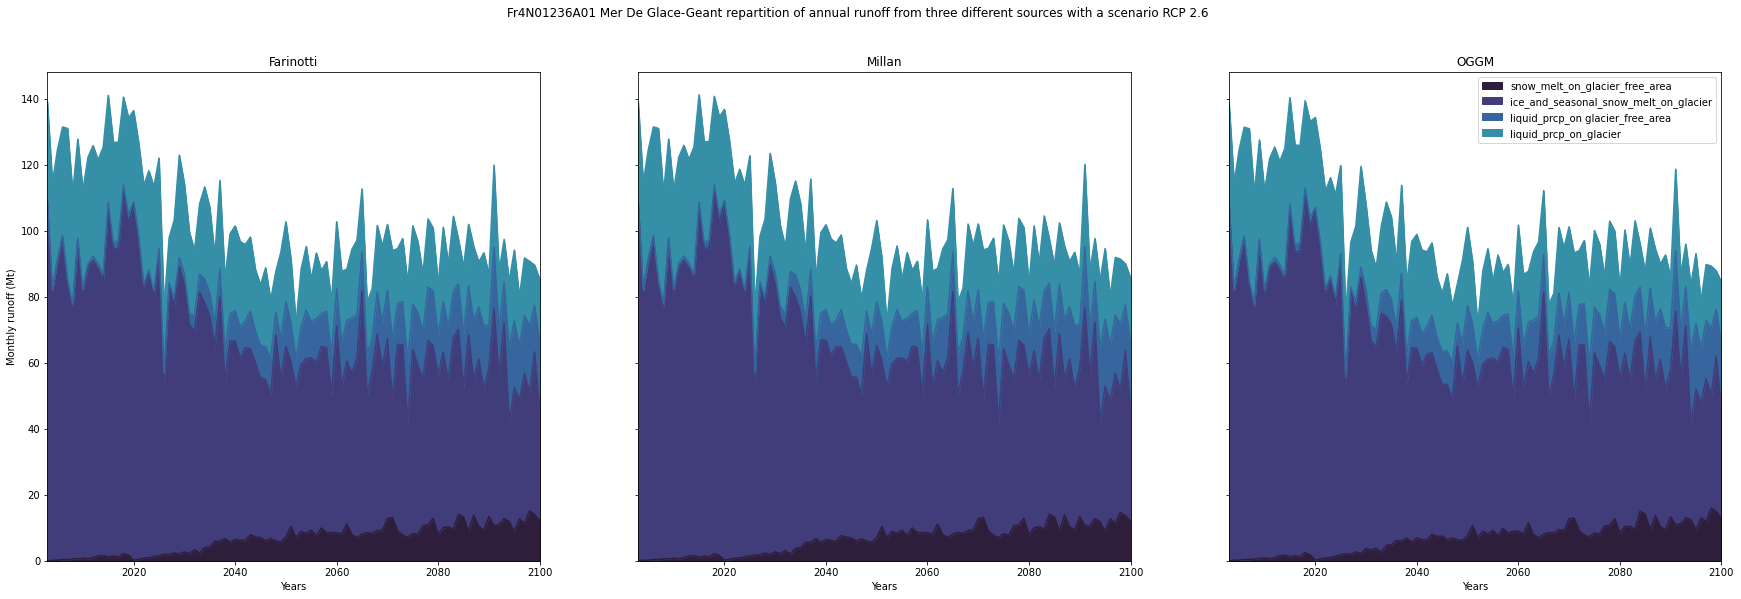

In [284]:
import seaborn as sns
f, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(30, 9),sharey=True)

for data in data_list: #loop all data sources
    d_p=out_evol[data][0]
    d_ptot=d_p
        
    d_h=out_hydro_hist[data]
    d_htot = d_h

    sel_vars = [v for v in d_ptot.variables if 'month_2d' not in d_ptot[v].dims]
    sel_vars_hist = [v for v in d_htot.variables if 'month_2d' not in d_htot[v].dims]
        
    # And create a dataframe
    dp_annual = d_ptot[sel_vars].to_dataframe()
    dh_annual = d_htot[sel_vars_hist].to_dataframe()

    # Select the variables relevant for runoff.
    runoff_vars = ['melt_off_glacier', 'melt_on_glacier','liq_prcp_off_glacier', 'liq_prcp_on_glacier']
        
    dp_runoff = dp_annual[runoff_vars].clip(0) * 1e-9
    dp_runoff = dp_runoff.droplevel('rgi_id') 
    dp_runoff = dp_runoff.drop([2101],axis=0)
        
    dh_runoff = dh_annual[runoff_vars].clip(0) * 1e-9
    dh_runoff = dh_runoff.drop([2020],axis=0)
        
    dp_runoff=pd.concat([dh_runoff,dp_runoff], axis=0) #historical and projections in the same Dataframe
    dp_runoff=dp_runoff.rename(columns={ "melt_off_glacier":"snow_melt_on_glacier_free_area",
                              "melt_on_glacier":"ice_and_seasonal_snow_melt_on_glacier",
                              "liq_prcp_off_glacier":"liquid_prcp_on glacier_free_area",
                              "liq_prcp_on_glacier":"liquid_prcp_on_glacier"})
    
    if (data=='farinotti'):
        dp_runoff.plot.area(ax=ax1, legend=False, title='Farinotti', color=sns.color_palette("mako"));
    elif(data=='millan'):
        dp_runoff.plot.area(ax=ax2, legend=False, title='Millan', color=sns.color_palette("mako")); 
    else:
        dp_runoff.plot.area(ax=ax3, title='OGGM', color=sns.color_palette("mako"));

plt.suptitle(''+gdir.name_corr+' repartition of annual runoff from three different sources with a scenario RCP 2.6')
ax1.set_ylabel('Monthly runoff (Mt)'); ax2.set_ylabel('Monthly runoff (Mt)'); ax3.set_ylabel('Monthly runoff (Mt)')
ax1.set_xlabel('Years'); ax2.set_xlabel('Years'); ax3.set_xlabel('Years')
ax1.set_xlim(2003,2100);ax2.set_xlim(2003,2100);ax3.set_xlim(2003,2100)
ax2.set_axis_on()
a=ax1.get_ybound()[1]
b=ax2.get_ybound()[1]
c=ax3.get_ybound()[1]
mm=max(a,b,c)
ax1.set_ylim(bottom=0,top=mm);ax2.set_ylim(bottom=0,top=mm);ax3.set_ylim(bottom=0,top=mm)

name = ''+gdir.name_corr+'_distrib_runoff__26_opt1.png'
plt.savefig(name, format = 'png')

## Plotting profiles

### Initial profil

In [285]:
df_surf=pd.concat([list_out_surf[1],list_out_surf[2],list_out_surf[0]], axis=1)
df_bed=pd.concat([list_out_bed[1],list_out_bed[2],list_out_bed[0]], axis=1)
df_surf.columns=['farinotti','millan','oggm']
df_bed.columns=['bed farinotti','bed millan','bed oggm']

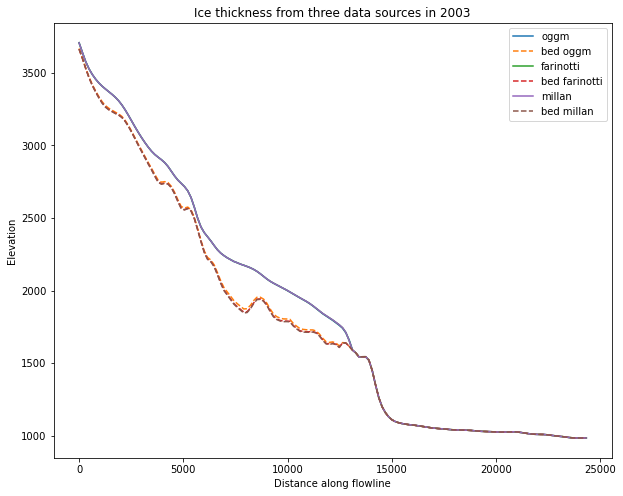

In [286]:
f, ax = plt.subplots(figsize=(10, 8))
for data in data_list:
    df_surf[[data]].plot(ax=ax);
    plt.legend()
    df_bed[['bed '+data+'']].plot(ax=ax,ylabel='Elevation',style="--");
    plt.legend()
plt.title('Ice thickness from three data sources in 2003');
name = ''+gdir.name_corr+'_profil_init_opt1.png'
plt.savefig(name, format = 'png')


### Profile in time for the three data sources

In [287]:
df_surf_farinotti=pd.concat([list_out_surf_evol[1][0],list_out_surf_evol[1][1],list_out_surf_evol[1][2],
                             list_out_surf_evol[1][3],list_out_surf_evol[1][4],list_out_surf_evol[1][5],
                             list_out_surf_evol[1][6],list_out_surf_evol[1][7]],axis=1)
df_surf_millan=pd.concat([list_out_surf_evol[2][0],list_out_surf_evol[2][1],list_out_surf_evol[2][2],
                          list_out_surf_evol[2][3],list_out_surf_evol[2][4],list_out_surf_evol[2][5],
                          list_out_surf_evol[2][6],list_out_surf_evol[2][7]], axis=1)
df_surf_oggm=pd.concat([list_out_surf_evol[0][0],list_out_surf_evol[0][1],list_out_surf_evol[0][2],
                        list_out_surf_evol[0][3],list_out_surf_evol[0][4],list_out_surf_evol[0][5],
                        list_out_surf_evol[0][6],list_out_surf_evol[0][7]], axis=1)

In [288]:
df_bed_2=pd.concat([list_out_bed_evol[1],list_out_bed_evol[2],list_out_bed_evol[0]], axis=1)

In [289]:
df_bed_2.columns=['bed farinotti','bed millan','bed oggm']

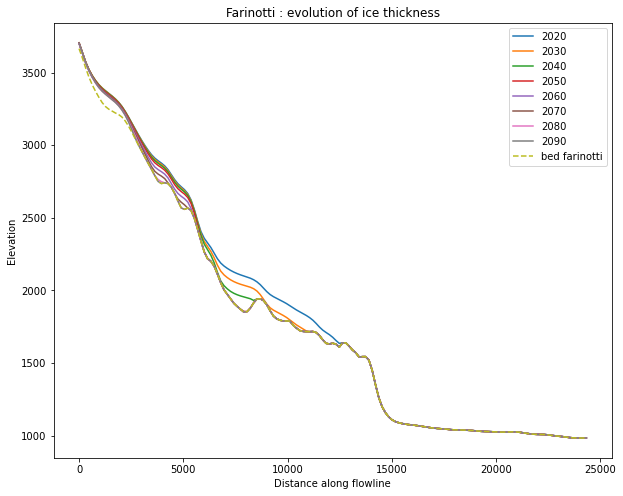

In [290]:
f, ax = plt.subplots(figsize=(10, 8))
for year in [2020,2030,2040,2050,2060,2070,2080,2090]:
    df_surf_farinotti[[year]].plot(ax=ax);
    plt.legend()
df_bed_2[['bed farinotti']].plot(ax=ax,ylabel='Elevation',style="--");
plt.legend()
plt.title('Farinotti : evolution of ice thickness');
name = ''+gdir.name_corr+'_profil_evol_f.png'
plt.savefig(name, format = 'png')

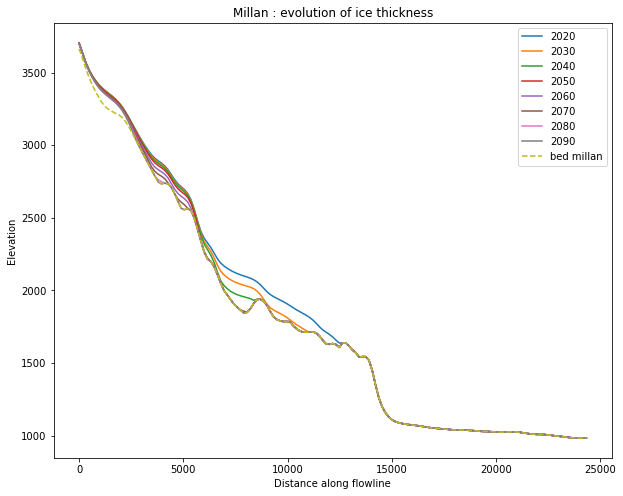

In [291]:
f, ax = plt.subplots(figsize=(10, 8))
for year in [2020,2030,2040,2050,2060,2070,2080,2090]:
    df_surf_millan[[year]].plot(ax=ax);
    plt.legend()
df_bed_2[['bed millan']].plot(ax=ax,ylabel='Elevation',style="--");
plt.legend()
plt.title('Millan : evolution of ice thickness');
name = ''+gdir.name_corr+'_profil_evol_m.png'
plt.savefig(name, format = 'png')

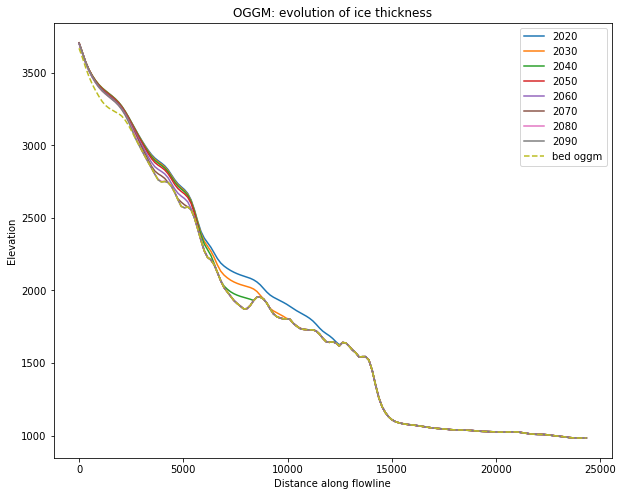

In [292]:
f, ax = plt.subplots(figsize=(10, 8))
for year in [2020,2030,2040,2050,2060,2070,2080,2090]:
    df_surf_oggm[[year]].plot(ax=ax);
    plt.legend()
df_bed_2[['bed oggm']].plot(ax=ax,ylabel='Elevation',style="--");
plt.legend()
plt.title('OGGM: evolution of ice thickness');
name = ''+gdir.name_corr+'_profil_evol_o.png'
plt.savefig(name, format = 'png')